# galah_dr4_thecannon_grid_interpolation_trainingset_creation

In [1]:
try:
    %matplotlib inline
    %config InlineBackend.figure_format='retina'
except:
    pass

import numpy as np
from astropy.table import Table
from scipy.io import readsav
from scipy.ndimage.filters import convolve
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
# Read in all available grids
grids = Table.read('../../spectrum_grids/galah_dr4_model_trainingset_gridpoints.fits')

In [3]:
# choose one grid_index
grid_index = 1931

try:
    teff_logg_feh_name = str(int(grids['teff_subgrid'][grid_index]))+'_'+"{:.2f}".format(grids['logg_subgrid'][grid_index])+'_'+"{:.2f}".format(grids['fe_h_subgrid'][grid_index])
    training_set_vsini0 = Table.read('../../spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'.fits')
    synthesis_files = '../../spectrum_grids/3d_bin_subgrids/'+teff_logg_feh_name
    print('Grid index '+str(grid_index)+' corresponds to '+teff_logg_feh_name)
except:
    raise ValueError('There are only '+str(len(grids))+' entries within the grid')

Grid index 1931 corresponds to 5750_4.50_0.00


### Below we define how to broaden a spectrum with a certain vsini value

In [4]:
def integrate_flux(mu, inten, deltav, vsini, vrt, osamp=1):
    """
    Produces a flux profile by integrating intensity profiles (sampled
    at various mu angles) over the visible stellar surface.
    Intensity profiles are weighted by the fraction of the projected
    stellar surface they represent, apportioning the area between
    adjacent MU points equally. Additional weights (such as those
    used in a Gauss-Legendre quadrature) can not meaningfully be
    used in this scheme.  About twice as many points are required
    with this scheme to achieve the precision of Gauss-Legendre
    quadrature.
    DELTAV, VSINI, and VRT must all be in the same units (e.g. km/s).
    If specified, OSAMP should be a positive integer.
    Parameters
    ----------
    mu : array(float) of size (nmu,)
        cosine of the angle between the outward normal and
        the line of sight for each intensity spectrum in INTEN.
    inten : array(float) of size(nmu, npts)
        intensity spectra at specified values of MU.
    deltav : float
        velocity spacing between adjacent spectrum points
        in INTEN (same units as VSINI and VRT).
    vsini : float
        maximum radial velocity, due to solid-body rotation.
    vrt : float
        radial-tangential macroturbulence parameter, i.e.
        np.sqrt(2) times the standard deviation of a Gaussian distribution
        of turbulent velocities. The same distribution function describes
        the radial motions of one component and the tangential motions of
        a second component. Each component covers half the stellar surface.
        See 'The Observation and Analysis of Stellar Photospheres', Gray.
    osamp : int, optional
        internal oversampling factor for convolutions.
        By default convolutions are done using the input points (OSAMP=1),
        but when OSAMP is set to higher integer values, the input spectra
        are first oversampled by cubic spline interpolation.
    Returns
    -------
    value : array(float) of size (npts,)
        Disk integrated flux profile.
    Note
    ------------
        If you use this algorithm in work that you publish, please cite
        Valenti & Anderson 1996, PASP, currently in preparation.
    """
    """
    History
    -----------
    Feb-88  GM
        Created ANA version.
    13-Oct-92 JAV
        Adapted from G. Marcy's ANA routi!= of the same name.
    03-Nov-93 JAV
        Switched to annular convolution technique.
    12-Nov-93 JAV
        Fixed bug. Intensity compo!=nts not added when vsini=0.
    14-Jun-94 JAV
        Reformatted for "public" release. Heavily commented.
        Pass deltav instead of 2.998d5/deltav. Added osamp
        keyword. Added rebinning logic at end of routine.
        Changed default osamp from 3 to 1.
    20-Feb-95 JAV
        Added mu as an argument to handle arbitrary mu sampling
        and remove ambiguity in intensity profile ordering.
        Interpret VTURB as np.sqrt(2)*sigma instead of just sigma.
        Replaced call_external with call to spl_{init|interp}.
    03-Apr-95 JAV
        Multiply flux by pi to give observed flux.
    24-Oct-95 JAV
        Force "nmk" padding to be at least 3 pixels.
    18-Dec-95 JAV
        Renamed from dskint() to rtint(). No longer make local
        copy of intensities. Use radial-tangential instead
        of isotropic Gaussian macroturbulence.
    26-Jan-99 JAV
        For NMU=1 and VSINI=0, assume resolved solar surface#
        apply R-T macro, but supress vsini broadening.
    01-Apr-99 GMH
        Use annuli weights, rather than assuming ==ual area.
    07-Mar-12 JAV
        Force vsini and vmac to be scalars.
    """

    # Make local copies of various input variables, which will be altered below.
    # Force vsini and especially vmac to be scalars. Otherwise mu dependence fails.

    if np.size(vsini) > 1:
        vsini = vsini[0]
    if np.size(vrt) > 1:
        vrt = vrt[0]

    # Determine oversampling factor.
    os = round(np.clip(osamp, 1, None))  # force integral value > 1

    # Convert input MU to projected radii, R, of annuli for a star of unit radius
    #  (which is just sine, rather than cosine, of the angle between the outward
    #  normal and the line of sight).
    rmu = np.sqrt(1 - mu ** 2)  # use simple trig identity

    # Sort the projected radii and corresponding intensity spectra into ascending
    #  order (i.e. from disk center to the limb), which is equivalent to sorting
    #  MU in descending order.
    isort = np.argsort(rmu)
    rmu = rmu[isort]  # reorder projected radii
    nmu = np.size(mu)  # number of radii
    if nmu == 1:
        if vsini != 0:
            logger.warning(
                "Vsini is non-zero, but only one projected radius (mu value) is set. No rotational broadening will be performed."
            )
            vsini = 0  # ignore vsini if only 1 mu

    # Calculate projected radii for boundaries of disk integration annuli.  The n+1
    # boundaries are selected such that r(i+1) exactly bisects the area between
    # rmu(i) and rmu(i+1). The in!=rmost boundary, r(0) is set to 0 (disk center)
    # and the outermost boundary, r(nmu) is set to 1 (limb).
    if nmu > 1 or vsini != 0:  # really want disk integration
        r = np.sqrt(
            0.5 * (rmu[:-1] ** 2 + rmu[1:] ** 2)
        )  # area midpoints between rmu
        r = np.concatenate(([0], r, [1]))

        # Calculate integration weights for each disk integration annulus.  The weight
        # is just given by the relative area of each annulus, normalized such that
        # the sum of all weights is unity.  Weights for limb darkening are included
        # explicitly in the intensity profiles, so they aren't needed here.
        wt = r[1:] ** 2 - r[:-1] ** 2  # weights = relative areas
    else:
        wt = np.array([1.0])  # single mu value, full weight

    # Generate index vectors for input and oversampled points. Note that the
    # oversampled indicies are carefully chosen such that every "os" finely
    # sampled points fit exactly into one input bin. This makes it simple to
    # "integrate" the finely sampled points at the end of the routine.
    npts = inten.shape[1]  # number of points
    xpix = np.arange(npts, dtype=float)  # point indices
    nfine = os * npts  # number of oversampled points
    xfine = (0.5 / os) * (
        2 * np.arange(nfine, dtype=float) - os + 1
    )  # oversampled points indices

    # Loop through annuli, constructing and convolving with rotation kernels.

    yfine = np.empty(nfine)  # init oversampled intensities
    flux = np.zeros(nfine)  # init flux vector
    for imu in range(nmu):  # loop thru integration annuli

        #  Use external cubic spline routine (adapted from Numerical Recipes) to make
        #  an oversampled version of the intensity profile for the current annulus.
        ypix = inten[isort[imu]]  # extract intensity profile
        if os == 1:
            # just copy (use) original profile
            yfine = ypix
        else:
            # spline onto fine wavelength scale
            yfine = interp1d(xpix, ypix, kind="cubic")(xfine)

        # Construct the convolution kernel which describes the distribution of
        # rotational velocities present in the current annulus. The distribution has
        # been derived analytically for annuli of arbitrary thickness in a rigidly
        # rotating star. The kernel is constructed in two pieces: o!= piece for
        # radial velocities less than the maximum velocity along the inner edge of
        # the annulus, and one piece for velocities greater than this limit.
        if vsini > 0:
            # nontrivial case
            r1 = r[imu]  # inner edge of annulus
            r2 = r[imu + 1]  # outer edge of annulus
            dv = deltav / os  # oversampled velocity spacing
            maxv = vsini * r2  # maximum velocity in annulus
            nrk = 2 * int(maxv / dv) + 3  ## oversampled kernel point
            # velocity scale for kernel
            v = dv * (np.arange(nrk, dtype=float) - ((nrk - 1) / 2))
            rkern = np.zeros(nrk)  # init rotational kernel
            j1 = np.abs(v) < vsini * r1  # low velocity points
            rkern[j1] = np.sqrt((vsini * r2) ** 2 - v[j1] ** 2) - np.sqrt(
                (vsini * r1) ** 2 - v[j1] ** 2
            )  # generate distribution

            j2 = (np.abs(v) >= vsini * r1) & (np.abs(v) <= vsini * r2)
            rkern[j2] = np.sqrt(
                (vsini * r2) ** 2 - v[j2] ** 2
            )  # generate distribution

            rkern = rkern / np.sum(rkern)  # normalize kernel

            # Convolve the intensity profile with the rotational velocity kernel for this
            # annulus. Pad each end of the profile with as many points as are in the
            # convolution kernel. This reduces Fourier ringing. The convolution may also
            # be do!= with a routi!= called "externally" from IDL, which efficiently
            # shifts and adds.
            if nrk > 3:
                yfine = convolve(yfine, rkern, mode="nearest")

        # Calculate projected sigma for radial and tangential velocity distributions.
        muval = mu[isort[imu]]  # current value of mu
        sigma = os * vrt / np.sqrt(2) / deltav  # standard deviation in points
        sigr = sigma * muval  # reduce by current mu value
        sigt = sigma * np.sqrt(1.0 - muval ** 2)  # reduce by np.sqrt(1-mu**2)

        # Figure out how many points to use in macroturbulence kernel.
        nmk = int(10 * sigma)
        nmk = np.clip(nmk, 3, (nfine - 3) // 2)

        # Construct radial macroturbulence kernel with a sigma of mu*VRT/np.sqrt(2).
        if sigr > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigr
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mrkern = np.exp(xarg)  # compute the gaussian
            mrkern = mrkern / np.sum(mrkern)  # normalize the profile
        else:
            mrkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mrkern[nmk] = 1.0  # delta function

        # Construct tangential kernel with a sigma of np.sqrt(1-mu**2)*VRT/np.sqrt(2).
        if sigt > 0:
            xarg = np.linspace(-nmk, nmk, 2 * nmk + 1) / sigt
            xarg = np.clip(-0.5 * xarg ** 2, -20, None)
            mtkern = np.exp(xarg)  # compute the gaussian
            mtkern = mtkern / np.sum(mtkern)  # normalize the profile
        else:
            mtkern = np.zeros(2 * nmk + 1)  # init with 0d0
            mtkern[nmk] = 1.0  # delta function

        # Sum the radial and tangential components, weighted by surface area.
        area_r = 0.5  # assume equal areas
        area_t = 0.5  # ar+at must equal 1
        mkern = area_r * mrkern + area_t * mtkern  # add both components

        # Convolve the total flux profiles, again padding the spectrum on both ends to
        # protect against Fourier ringing.
        yfine = convolve(
            yfine, mkern, mode="nearest"
        )  # add the padding and convolve

        # Add contribution from current annulus to the running total.
        flux = flux + wt[imu] * yfine  # add profile to running total

    flux = np.reshape(flux, (npts, os))  # convert to an array
    flux = np.pi * np.sum(flux, axis=1) / os  # sum, normalize
    return flux

In [5]:
def broaden_spectrum(wint_seg, sint_seg, wave_seg, cmod_seg, vsini=0, vmac=0, debug=False):

    nw = len(wint_seg)
    clight = 299792.5
    mu = (np.sqrt(0.5*(2*np.arange(7)+1)/np.float(7)))[::-1]
    nmu = 7
    wmid = 0.5 * (wint_seg[nw-1] + wint_seg[0])
    wspan = wint_seg[nw-1] - wint_seg[0]
    jmin = np.argmin(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep1 = min(wint_seg[1:nw-1] - wint_seg[0:nw-2])
    vstep2 = 0.1 * wspan / (nw-1) / wmid * clight
    vstep3 = 0.05
    vstep = np.max([vstep1,vstep2,vstep3])

    # Generate model wavelength scale X, with uniform wavelength step.
    nx = int(np.floor(np.log10(wint_seg[nw-1] / wint_seg[0])/ np.log10(1.0+vstep / clight))+1)
    if nx % 2 == 0: nx += 1
    resol_out = 1.0/((wint_seg[nw-1] / wint_seg[0])**(1.0/(nx-1.0))-1.0)
    vstep = clight / resol_out
    x_seg = wint_seg[0] * (1.0 + 1.0 / resol_out)**np.arange(nx)

    # Interpolate intensity spectra onto new model wavelength scale.  
    yi_seg = np.empty((nmu, nx))

    for imu in range(nmu):
        yi_seg[imu] = np.interp(x_seg, wint_seg, sint_seg[imu])

    y_seg = integrate_flux(mu, yi_seg, vstep, np.abs(vsini), np.abs(vmac))

    dispersion = vstep1
    wave_equi = np.arange(x_seg[0],x_seg[-1]+dispersion,dispersion)

    c_seg = np.interp(wave_equi,wave_seg,cmod_seg)
    y_seg = np.interp(wave_equi,x_seg,y_seg)

    if debug:
        print(vstep1,len(wave_equi))
    
    return(wave_equi,y_seg/c_seg)

In [6]:
vsini_values = np.array([1.5, 3.0, 6.0, 9.0, 12.0, 24.0]) # km/s

# Gradient Spectra

In [7]:
null_spectrum_broad = dict()
for ccd in [1,2,3,4]:
    null_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_0_'+str(ccd)+'.out').results[0]
    null_spectrum_broad['wave_null_ccd'+str(ccd)],null_spectrum_broad['spectrum_null_ccd'+str(ccd)] = broaden_spectrum(
            null_spectrum.wint,
            null_spectrum.sint,
            null_spectrum.wave,
            null_spectrum.cmod,
            vsini = vsini_values[-1]
        )
print('The synthetic spectra come with keywords ',null_spectrum.dtype.names)

The synthetic spectra come with keywords  ('WAVE', 'SMOD', 'CMOD', 'WINT', 'SINT')


In [8]:
labels = np.array(training_set_vsini0.keys()[2:-1])
labels

array(['teff', 'logg', 'fe_h', 'vmic', 'li_fe', 'c_fe', 'n_fe', 'o_fe',
       'na_fe', 'mg_fe', 'al_fe', 'si_fe', 'k_fe', 'ca_fe', 'sc_fe',
       'ti_fe', 'v_fe', 'cr_fe', 'mn_fe', 'co_fe', 'ni_fe', 'cu_fe',
       'zn_fe', 'rb_fe', 'sr_fe', 'y_fe', 'zr_fe', 'mo_fe', 'ru_fe',
       'ba_fe', 'la_fe', 'ce_fe', 'nd_fe', 'sm_fe', 'eu_fe'], dtype='<U5')

In [36]:
fancy_labels = []
for label in labels:
    if label == 'teff':
        fancy_labels.append(r'$T_\mathrm{eff}~/~\mathrm{K}$')
    elif label == 'logg':
        fancy_labels.append(r'$\log (g~/~\mathrm{cm\,s^{-2}})$')
    elif label == 'fe_h':
        fancy_labels.append(r'$\mathrm{[Fe/H]}$')
    elif label == 'vmic':
        fancy_labels.append(r'$v_\mathrm{mic}~/~\mathrm{km\,s^{-1}}$')
    elif label == 'vsini':
        fancy_labels.append(r'$v \sin i~/~\mathrm{km\,s^{-1}}$')
    elif label[-3:] == '_fe':
        fancy_labels.append('$\mathrm{['+label[0].upper()+label[1:-3]+'/Fe]}$')
    else:
        print('No entry for '+label)
print(fancy_labels)

['$T_\\mathrm{eff}~/~\\mathrm{K}$', '$\\log (g~/~\\mathrm{cm\\,s^{-2}})$', '$\\mathrm{[Fe/H]}$', '$v_\\mathrm{mic}~/~\\mathrm{km\\,s^{-1}}$', '$\\mathrm{[Li/Fe]}$', '$\\mathrm{[C/Fe]}$', '$\\mathrm{[N/Fe]}$', '$\\mathrm{[O/Fe]}$', '$\\mathrm{[Na/Fe]}$', '$\\mathrm{[Mg/Fe]}$', '$\\mathrm{[Al/Fe]}$', '$\\mathrm{[Si/Fe]}$', '$\\mathrm{[K/Fe]}$', '$\\mathrm{[Ca/Fe]}$', '$\\mathrm{[Sc/Fe]}$', '$\\mathrm{[Ti/Fe]}$', '$\\mathrm{[V/Fe]}$', '$\\mathrm{[Cr/Fe]}$', '$\\mathrm{[Mn/Fe]}$', '$\\mathrm{[Co/Fe]}$', '$\\mathrm{[Ni/Fe]}$', '$\\mathrm{[Cu/Fe]}$', '$\\mathrm{[Zn/Fe]}$', '$\\mathrm{[Rb/Fe]}$', '$\\mathrm{[Sr/Fe]}$', '$\\mathrm{[Y/Fe]}$', '$\\mathrm{[Zr/Fe]}$', '$\\mathrm{[Mo/Fe]}$', '$\\mathrm{[Ru/Fe]}$', '$\\mathrm{[Ba/Fe]}$', '$\\mathrm{[La/Fe]}$', '$\\mathrm{[Ce/Fe]}$', '$\\mathrm{[Nd/Fe]}$', '$\\mathrm{[Sm/Fe]}$', '$\\mathrm{[Eu/Fe]}$']


In [10]:
gradient_spectra_up = Table()
gradient_spectra_up['wave'] = np.concatenate(([null_spectrum_broad['wave_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
gradient_spectra_up['median'] = np.concatenate(([null_spectrum_broad['spectrum_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))

gradient_spectra_down = Table()
gradient_spectra_down['wave'] = np.concatenate(([null_spectrum_broad['wave_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))
gradient_spectra_down['median'] = np.concatenate(([null_spectrum_broad['spectrum_null_ccd'+str(ccd)] for ccd in [1,2,3,4]]))

In [11]:
for label_index, label in enumerate(labels):
    
    gradient_up = []
    gradient_down = []
    
    for ccd in [1,2,3,4]:
        increased_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_'+str(2+label_index)+'_'+str(ccd)+'.out').results[0]
        decreased_spectrum = readsav(synthesis_files+'/galah_dr4_cannon_trainingset_'+teff_logg_feh_name+'_'+str(37+label_index)+'_'+str(ccd)+'.out').results[0]
    
        wave_increase, spectrum_increase = broaden_spectrum(
            increased_spectrum.wint,
            increased_spectrum.sint,
            increased_spectrum.wave,
            increased_spectrum.cmod,
            vsini = vsini_values[-1]
        )
        
        wave_decrease, spectrum_decrease = broaden_spectrum(
            decreased_spectrum.wint,
            decreased_spectrum.sint,
            decreased_spectrum.wave,
            decreased_spectrum.cmod,
            vsini = vsini_values[-1]
        )
        
        gradient_up.append(spectrum_increase - null_spectrum_broad['spectrum_null_ccd'+str(ccd)])
        gradient_down.append(spectrum_decrease - null_spectrum_broad['spectrum_null_ccd'+str(ccd)])

    gradient_spectra_up[label] = np.concatenate((gradient_up))
    gradient_spectra_down[label] = np.concatenate((gradient_down))

teff 250.0
0.0001:    99.2% 63723
0.001:    85.1% 54680


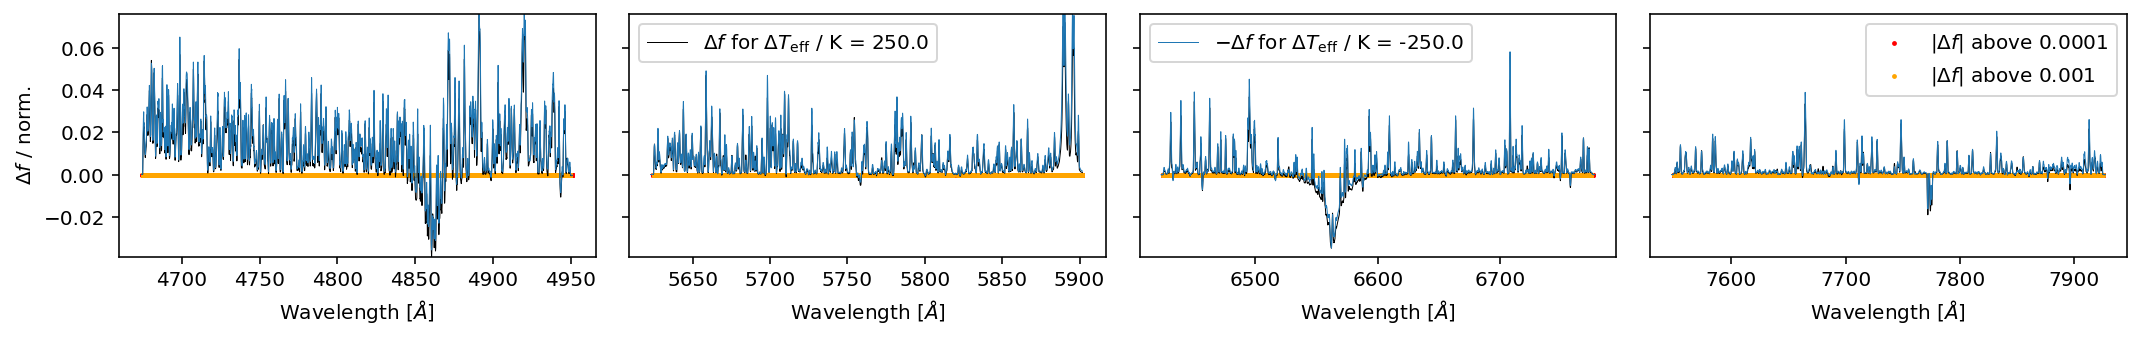

logg 0.5
0.0001:    93.3% 59889
0.001:    54.2% 34813


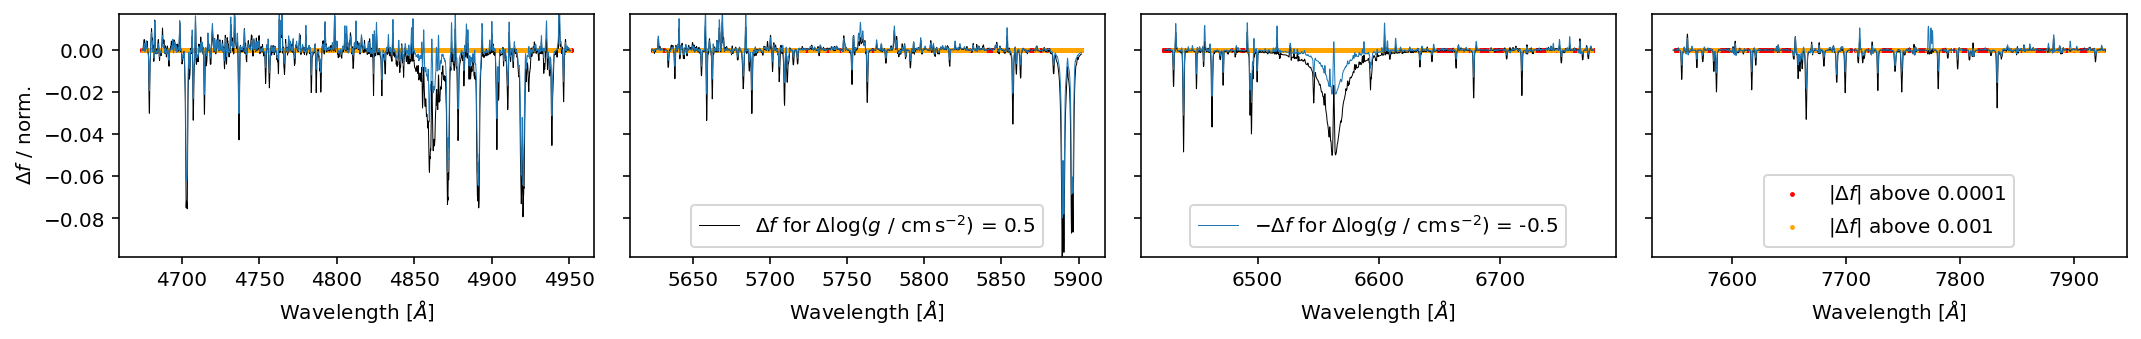

fe_h 0.25
0.0001:    99.6% 63941
0.001:    95.6% 61398


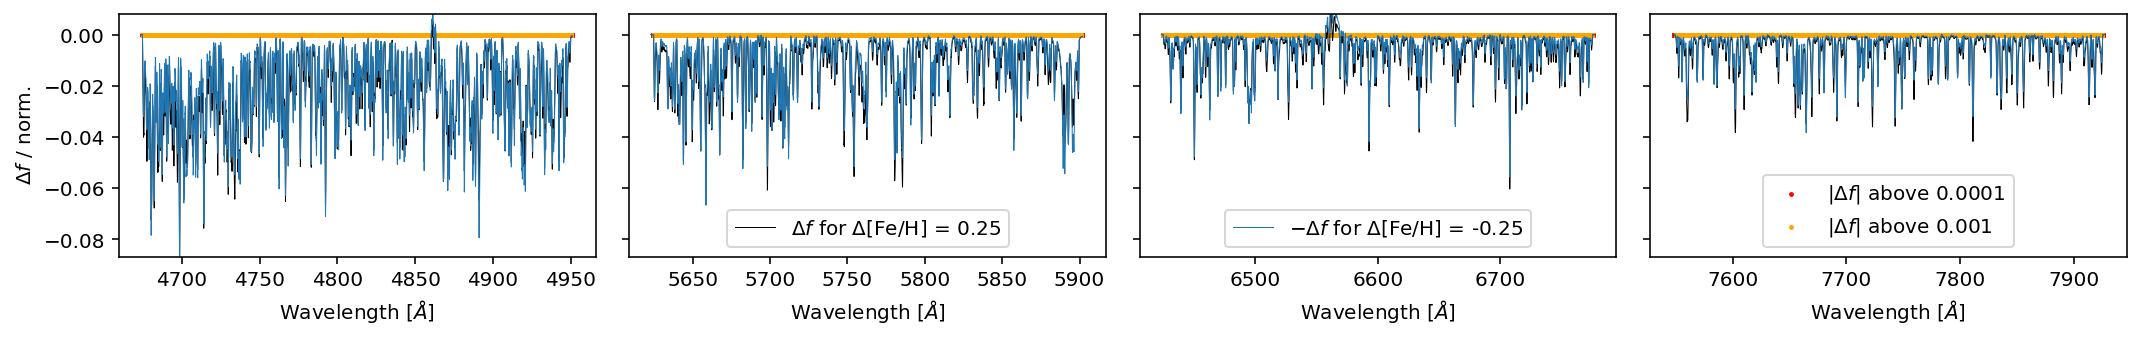

vmic 1.0
0.0001:    61.6% 39546
0.001:    39.8% 25588


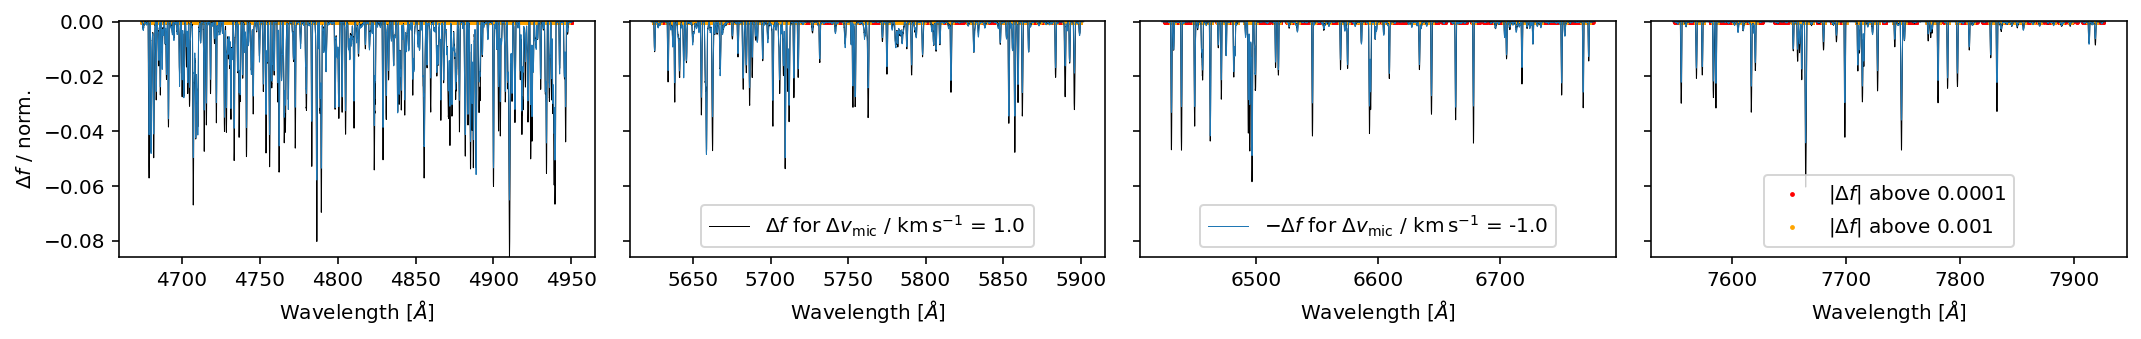

li_fe 2.25
0.0001:    1.9% 1219
0.001:    0.6% 381


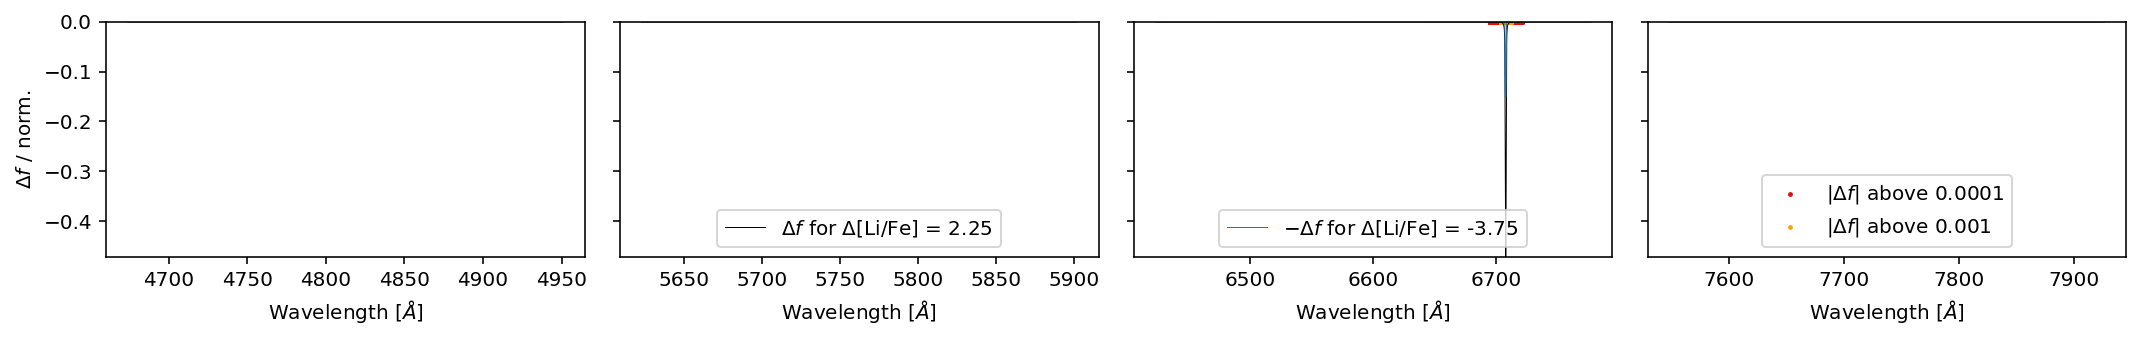

c_fe 1.0
0.0001:    99.2% 63706
0.001:    95.1% 61060


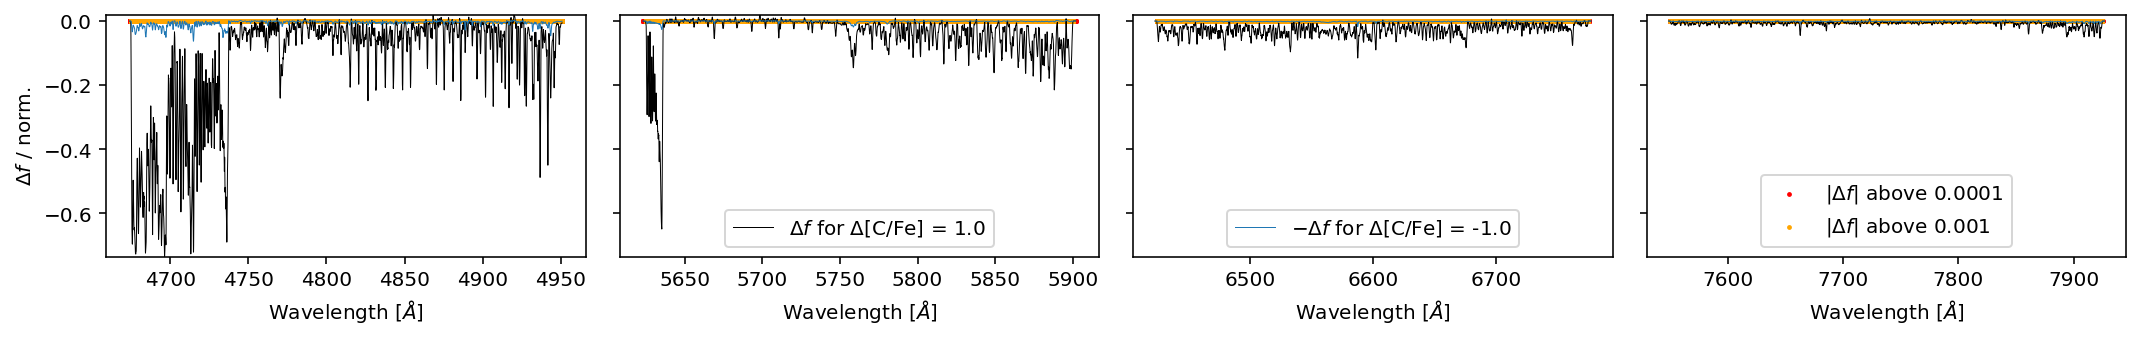

n_fe 1.0
0.0001:    98.3% 63123
0.001:    87.7% 56302


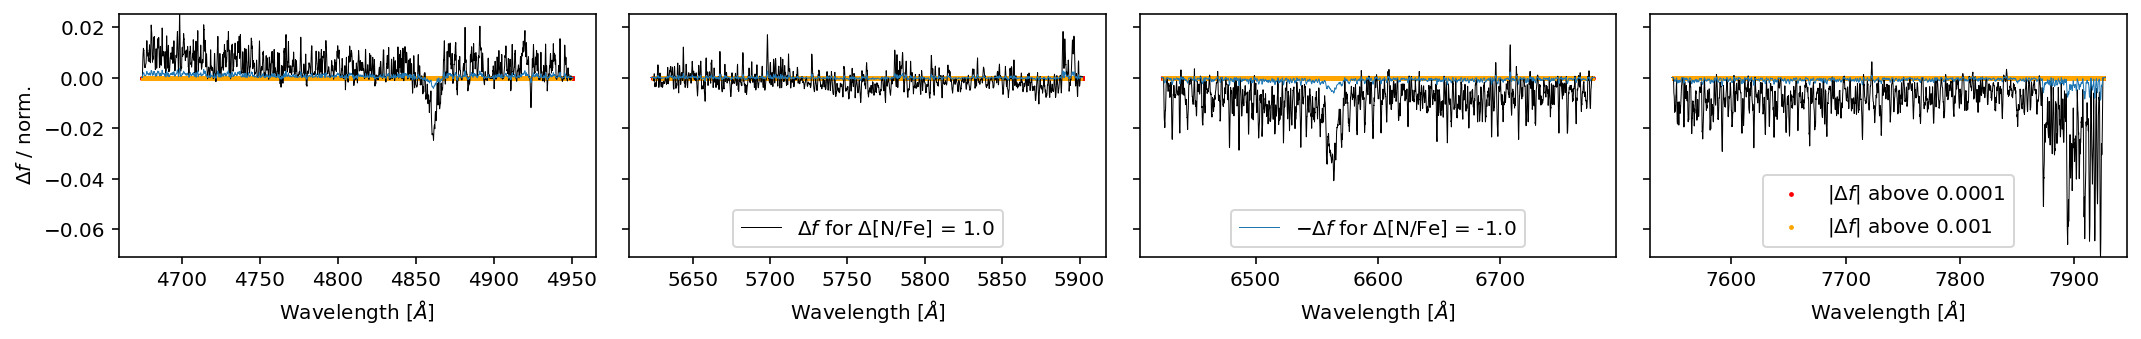

o_fe 2.0
0.0001:    98.6% 63356
0.001:    82.9% 53245


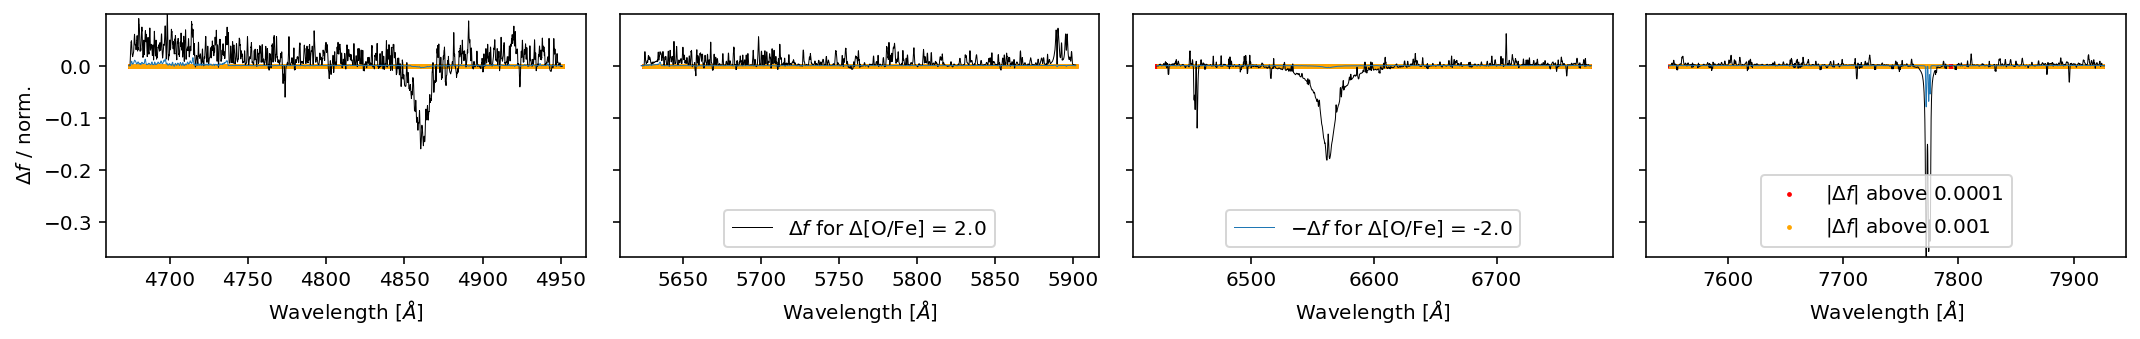

na_fe 1.0
0.0001:    74.0% 47544
0.001:    30.1% 19307


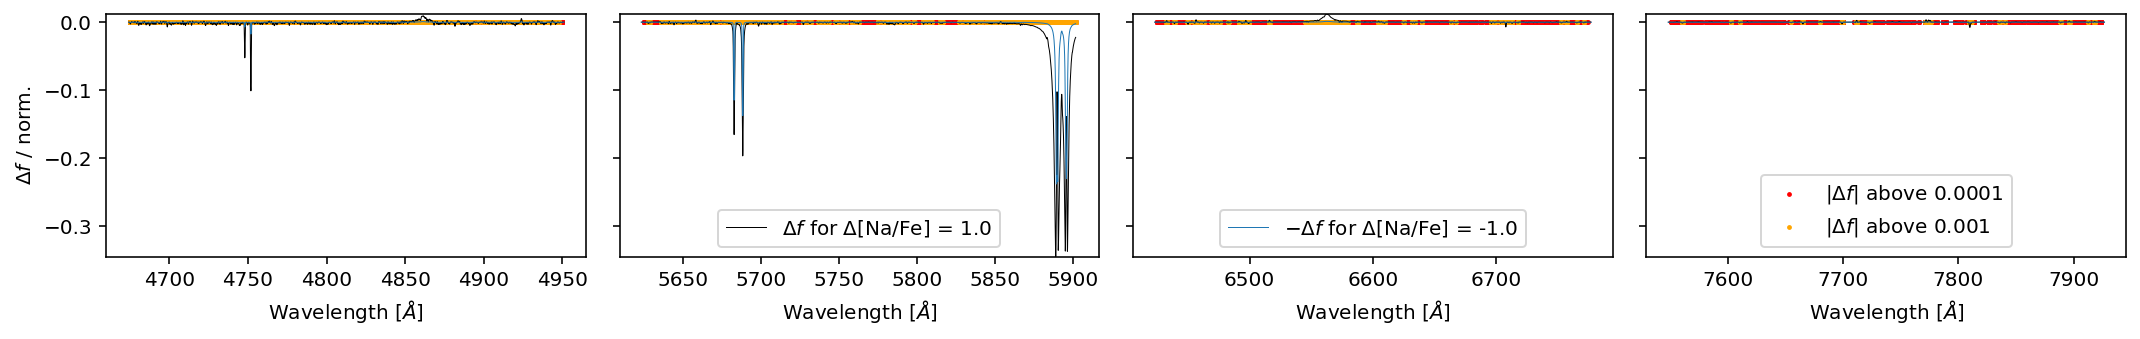

mg_fe 1.0
0.0001:    98.8% 63422
0.001:    82.2% 52804


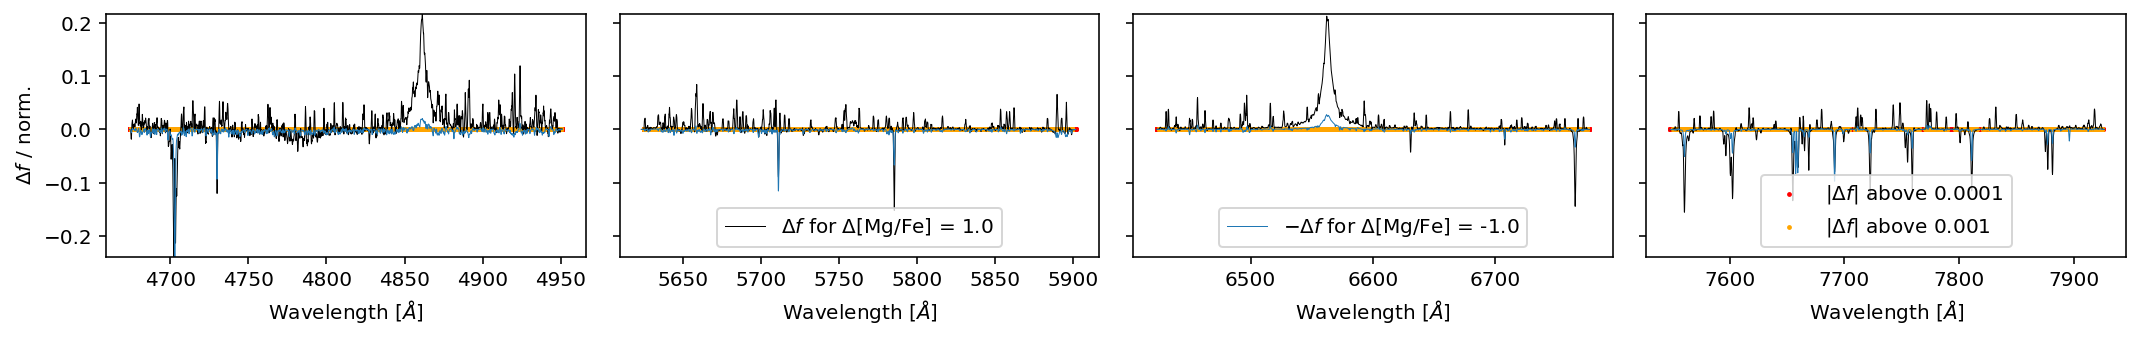

al_fe 1.0
0.0001:    78.2% 50229
0.001:    34.8% 22348


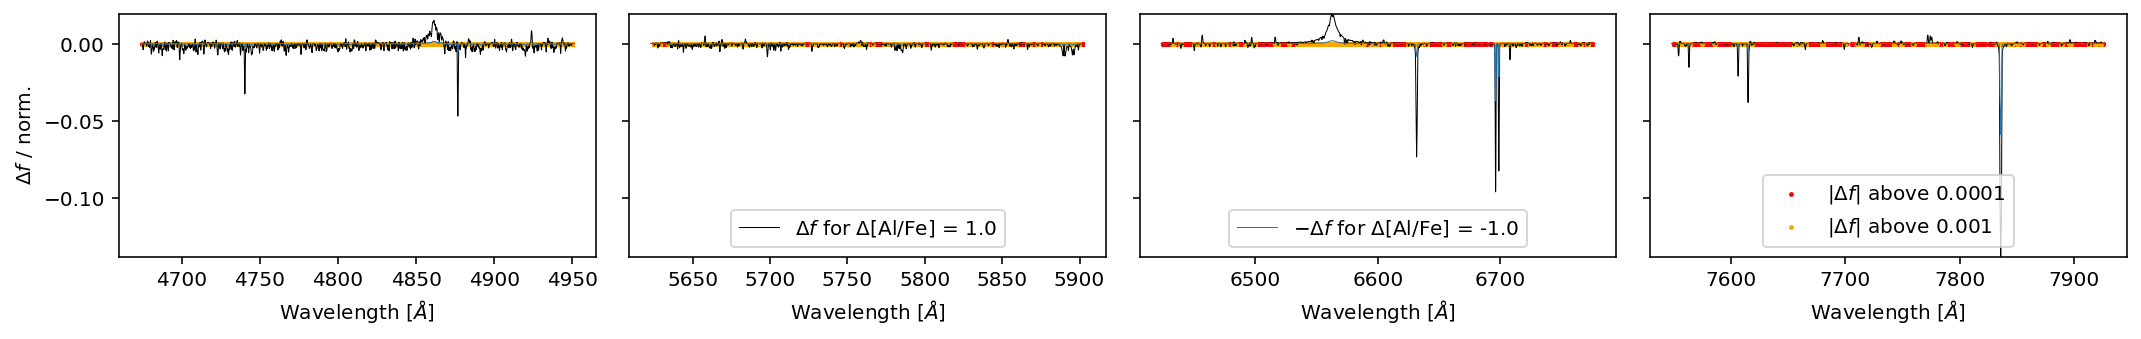

si_fe 1.0
0.0001:    97.6% 62696
0.001:    73.7% 47326


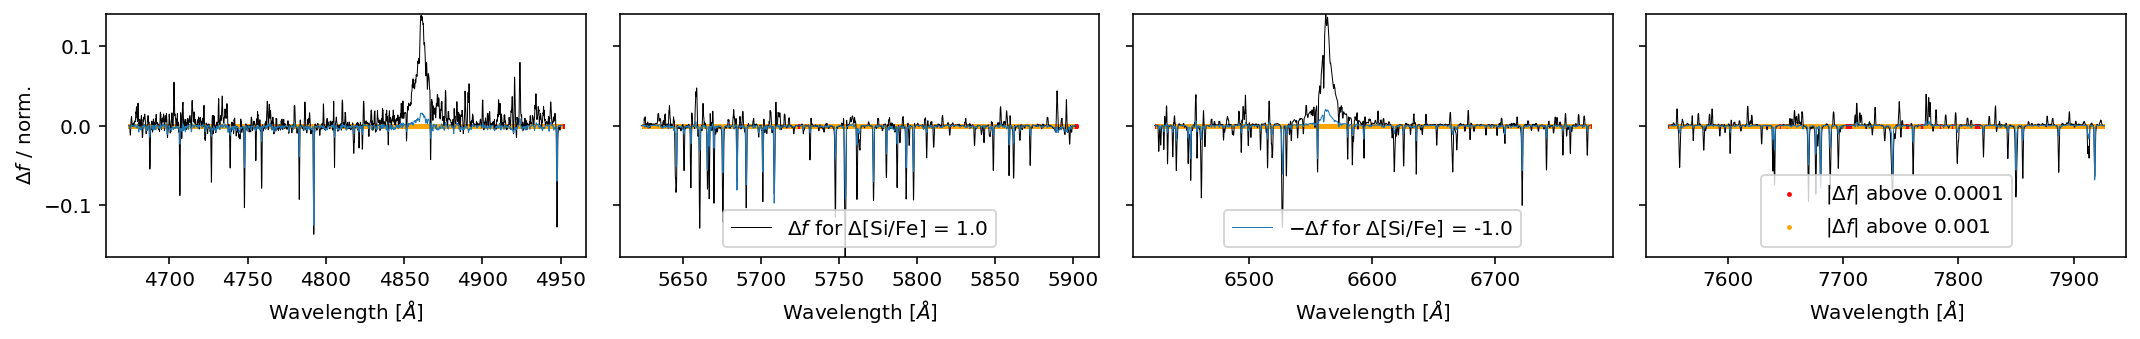

k_fe 1.0
0.0001:    29.1% 18705
0.001:    2.1% 1366


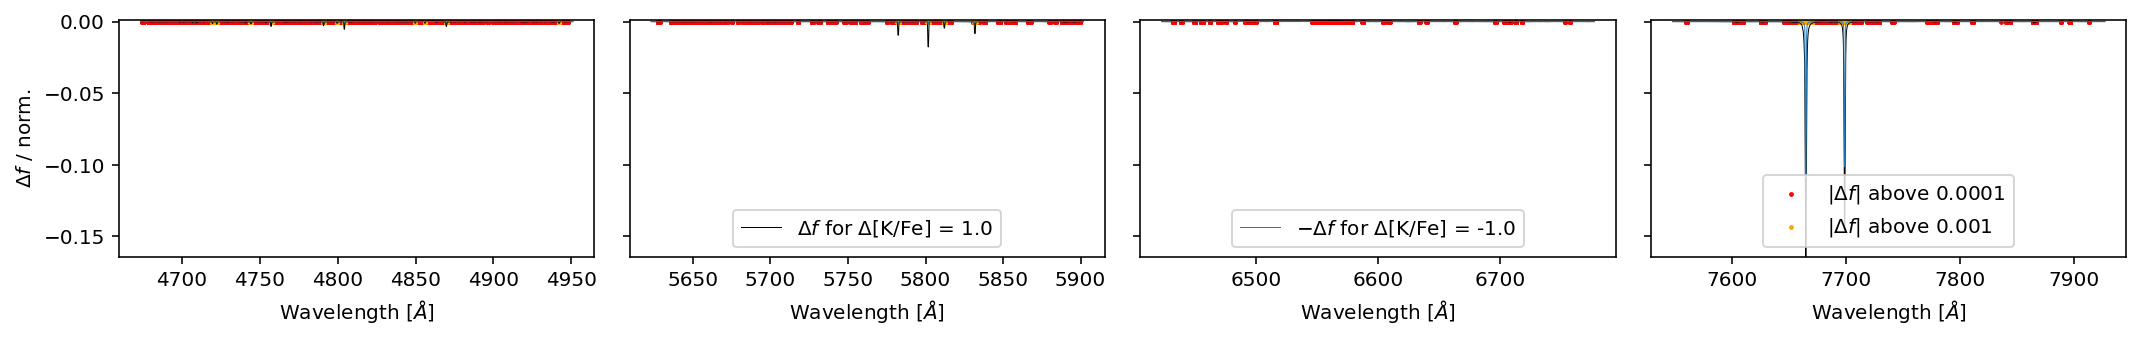

ca_fe 1.0
0.0001:    83.8% 53804
0.001:    44.8% 28752


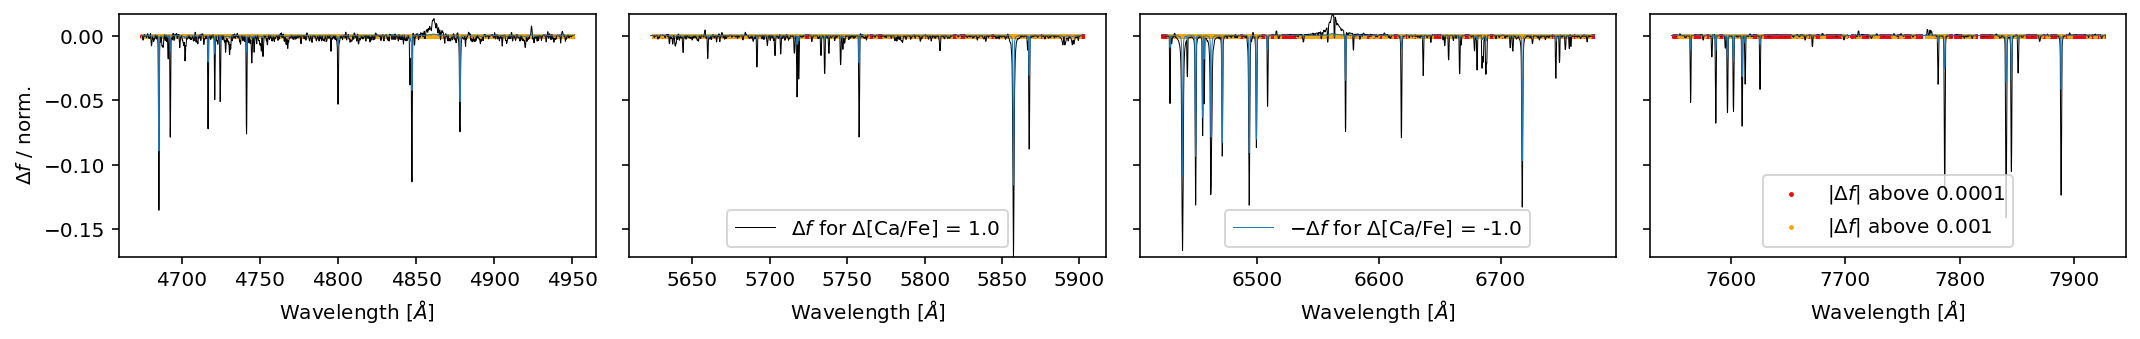

sc_fe 1.0
0.0001:    10.6% 6813
0.001:    4.8% 3110


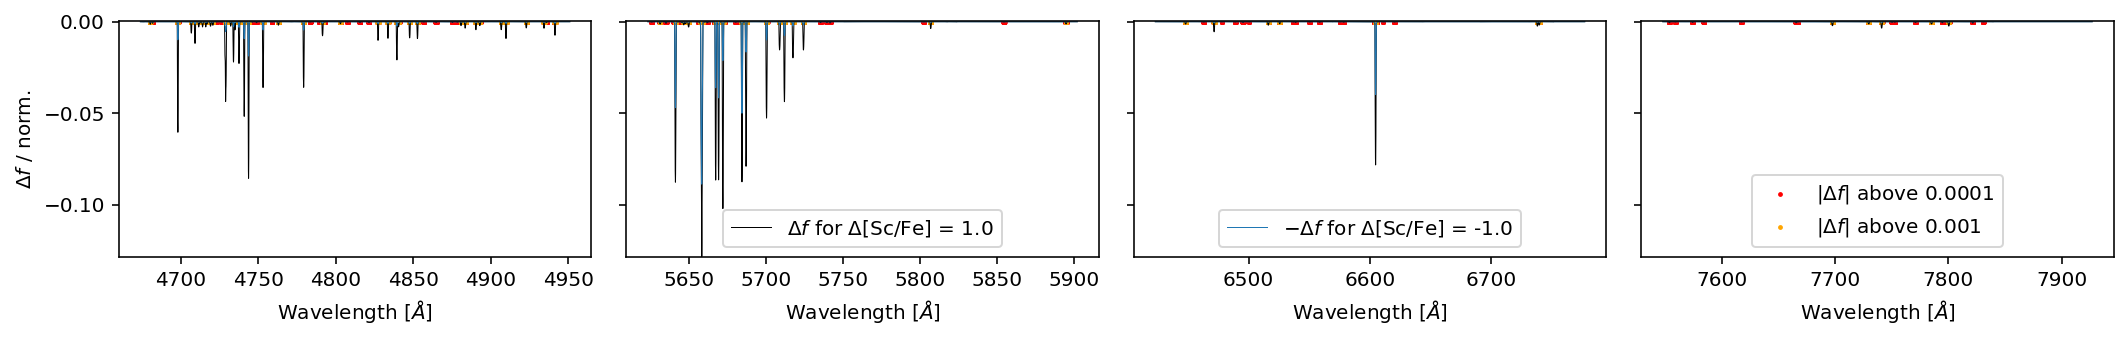

ti_fe 1.0
0.0001:    63.5% 40805
0.001:    32.9% 21131


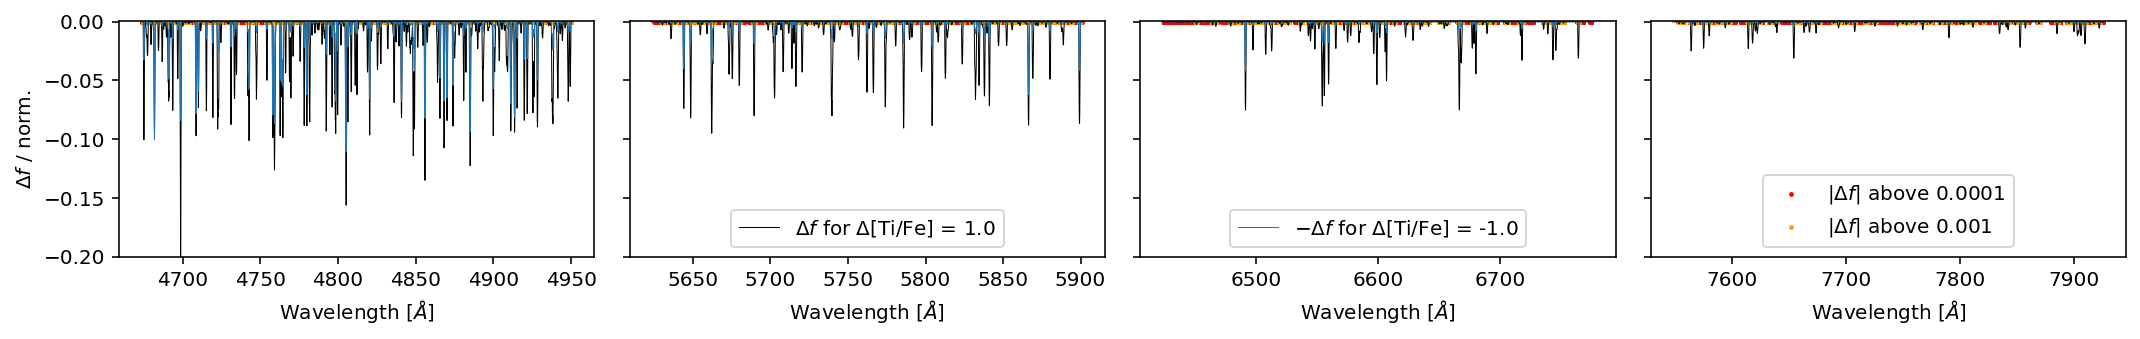

v_fe 1.0
0.0001:    35.5% 22772
0.001:    18.8% 12042


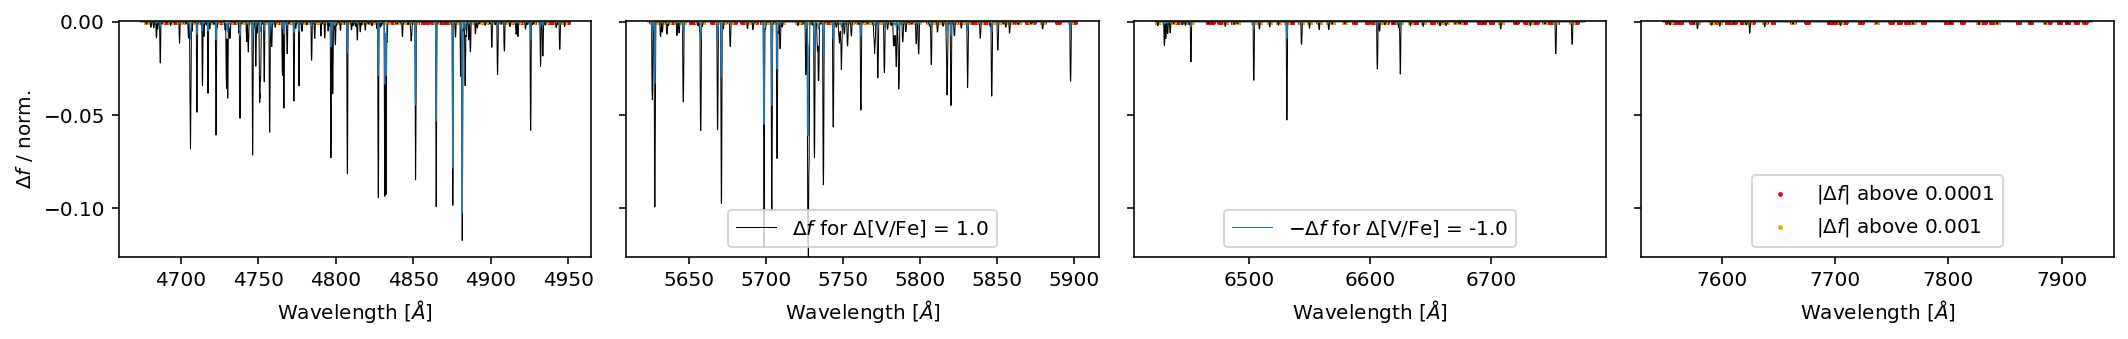

cr_fe 1.0
0.0001:    72.4% 46501
0.001:    38.0% 24432


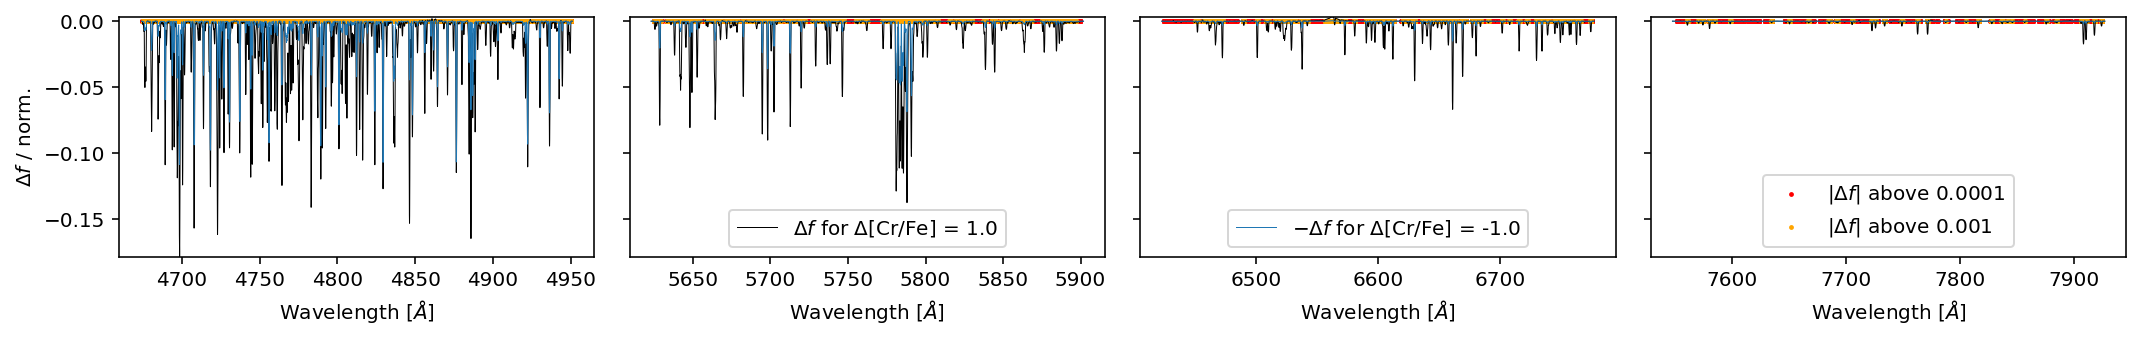

mn_fe 1.0
0.0001:    48.0% 30797
0.001:    13.7% 8825


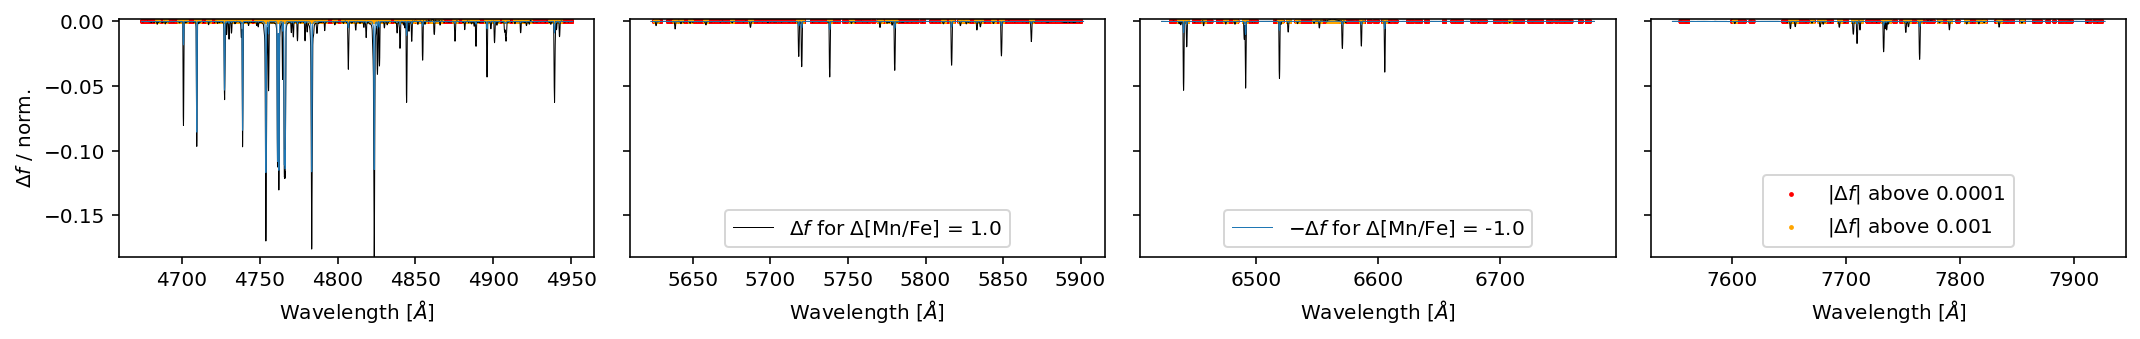

co_fe 1.0
0.0001:    39.7% 25475
0.001:    19.9% 12797


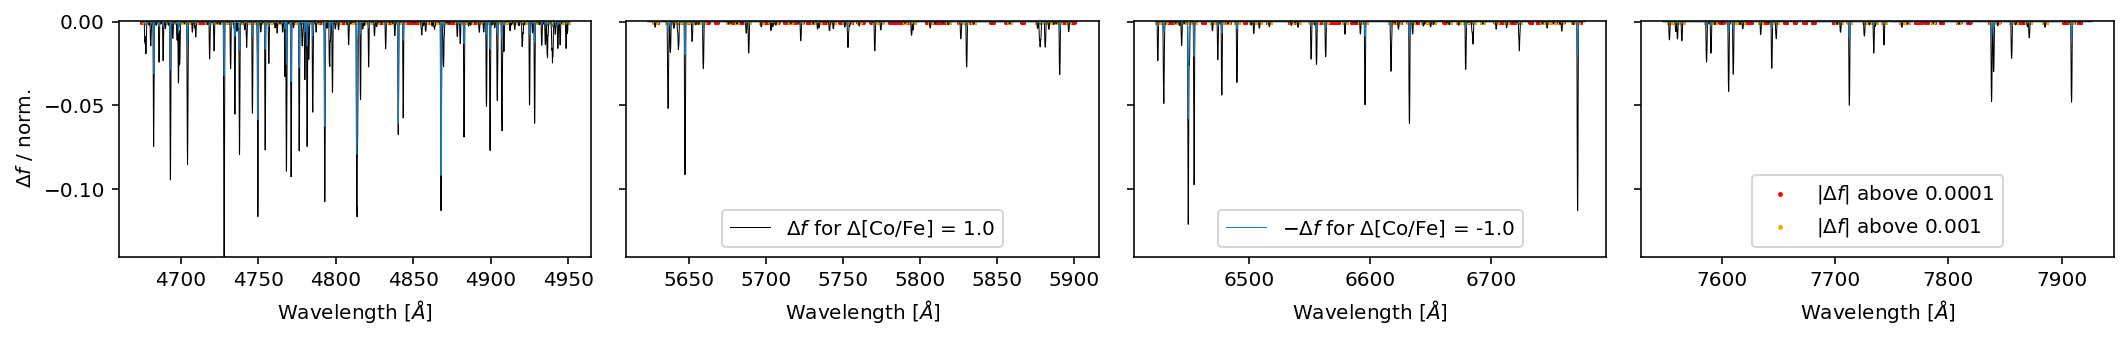

ni_fe 1.0
0.0001:    79.9% 51330
0.001:    43.4% 27852


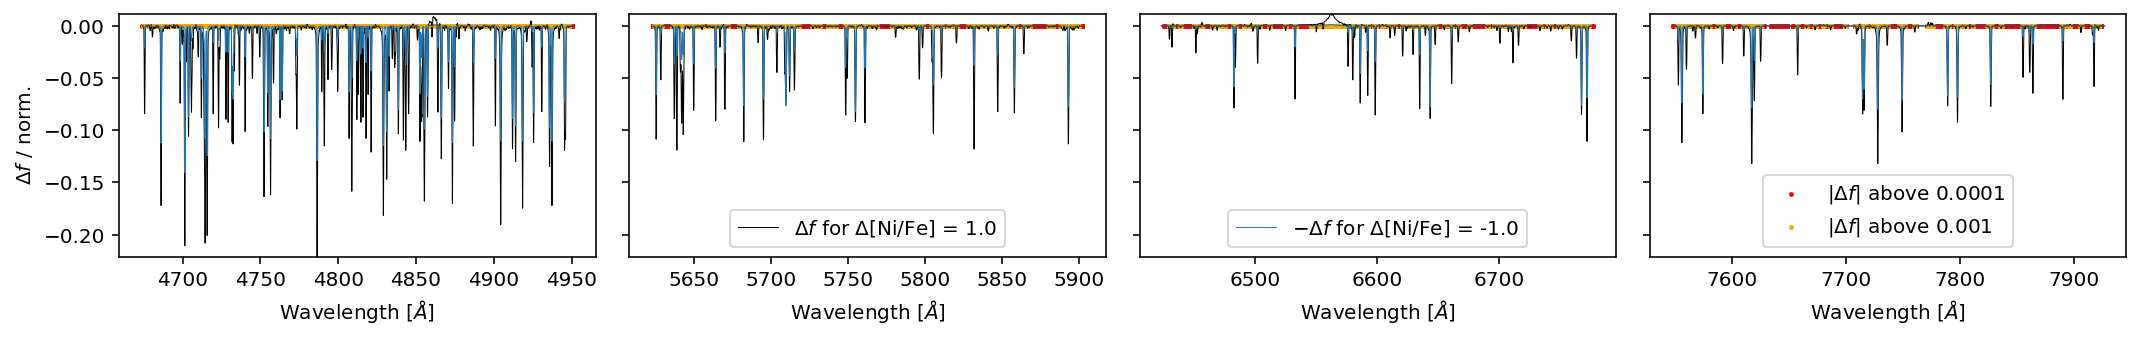

cu_fe 1.0
0.0001:    2.7% 1726
0.001:    0.8% 532


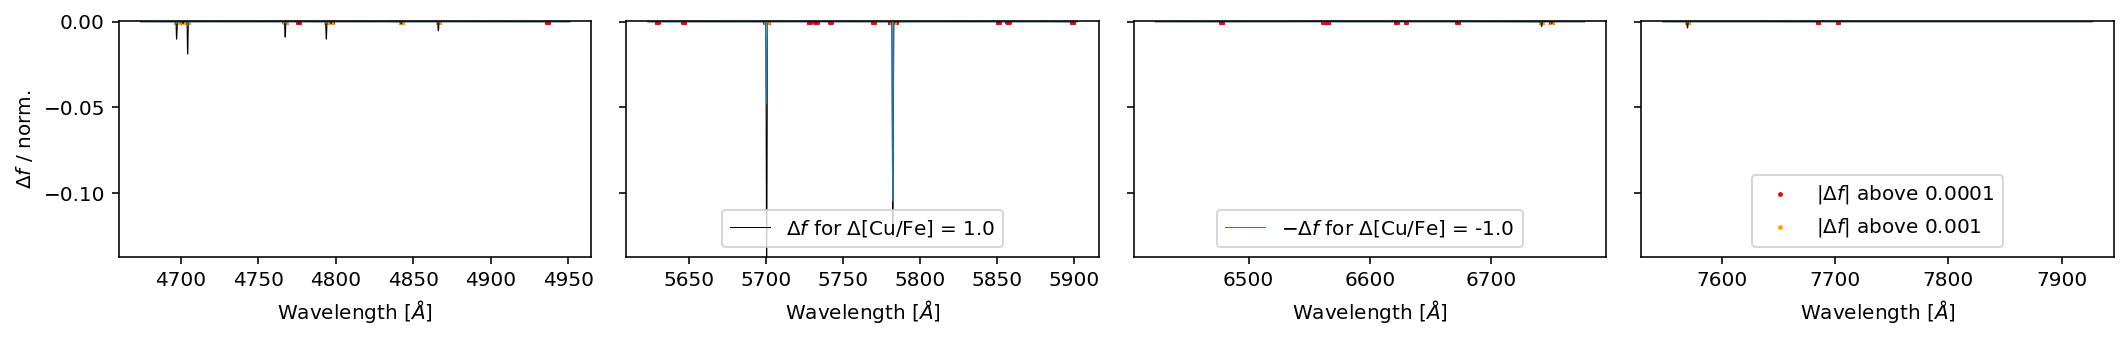

zn_fe 1.0
0.0001:    3.2% 2030
0.001:    0.8% 503


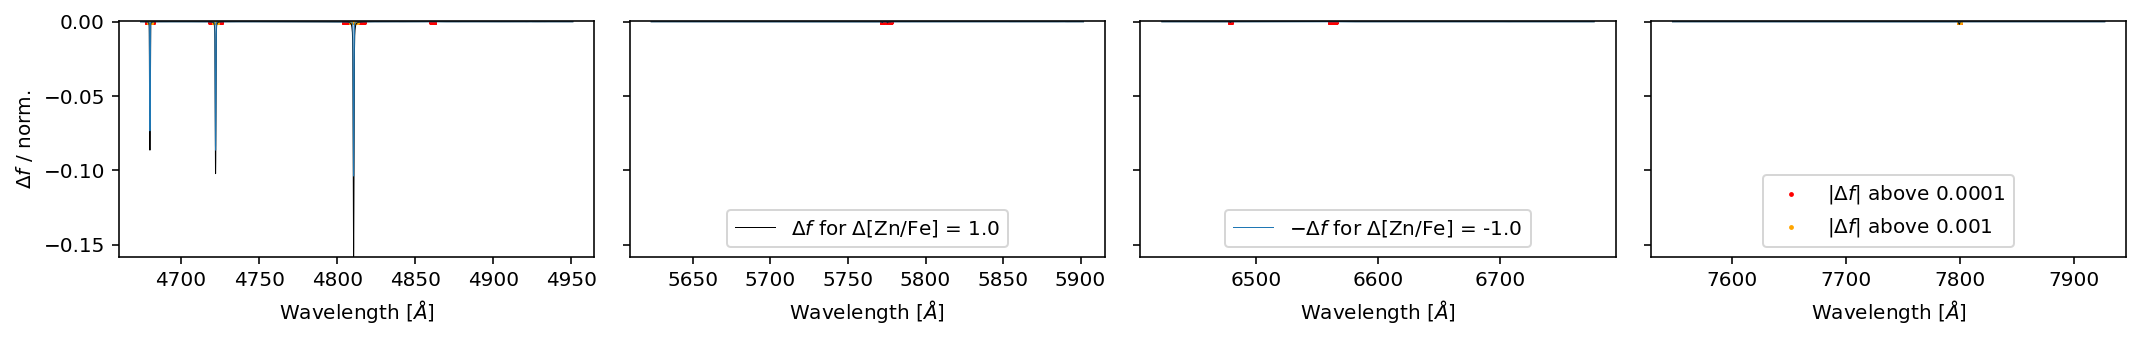

rb_fe 1.0
0.0001:    0.3% 175
0.001:    0.1% 54


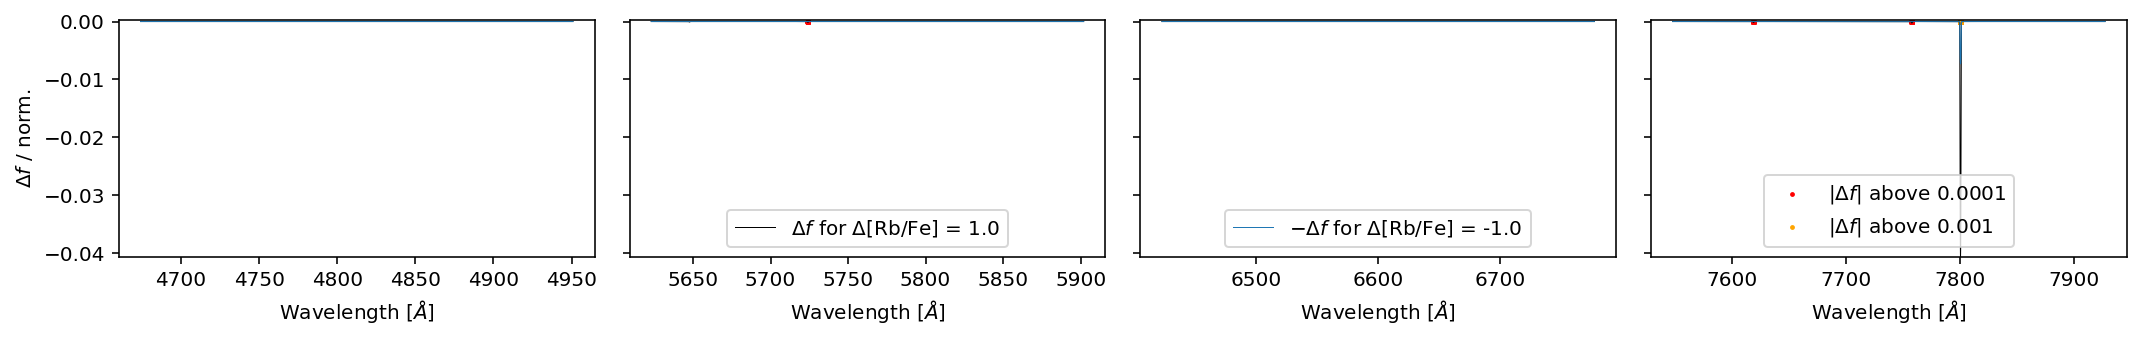

sr_fe 1.0
0.0001:    2.1% 1368
0.001:    1.5% 954


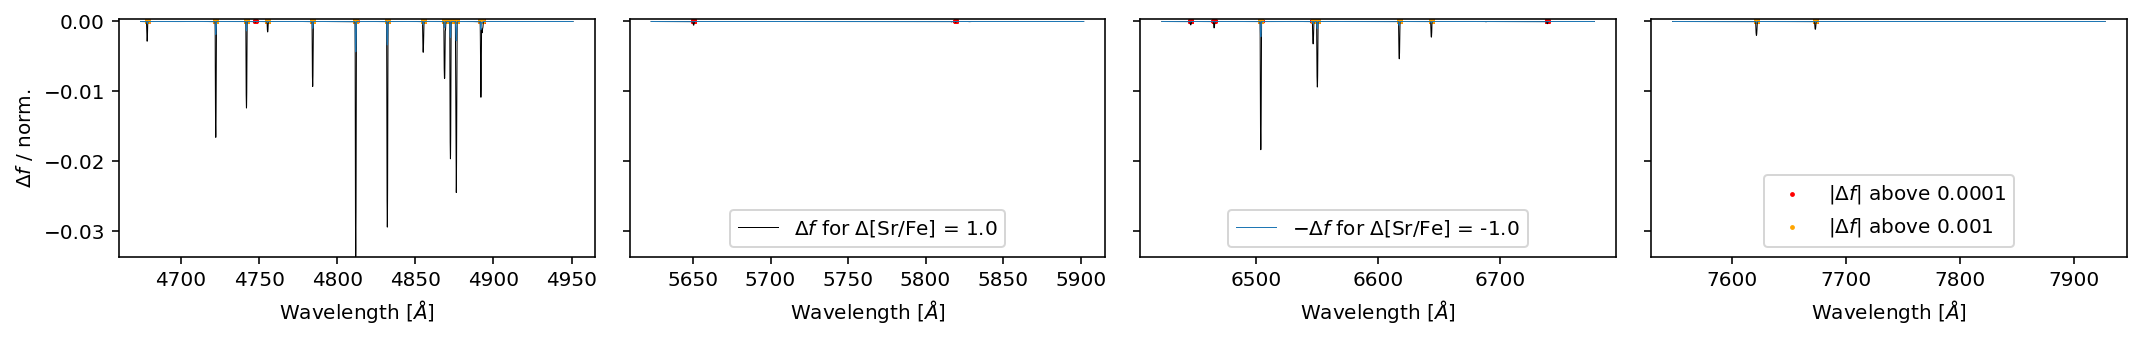

y_fe 2.0
0.0001:    20.8% 13383
0.001:    9.3% 6004


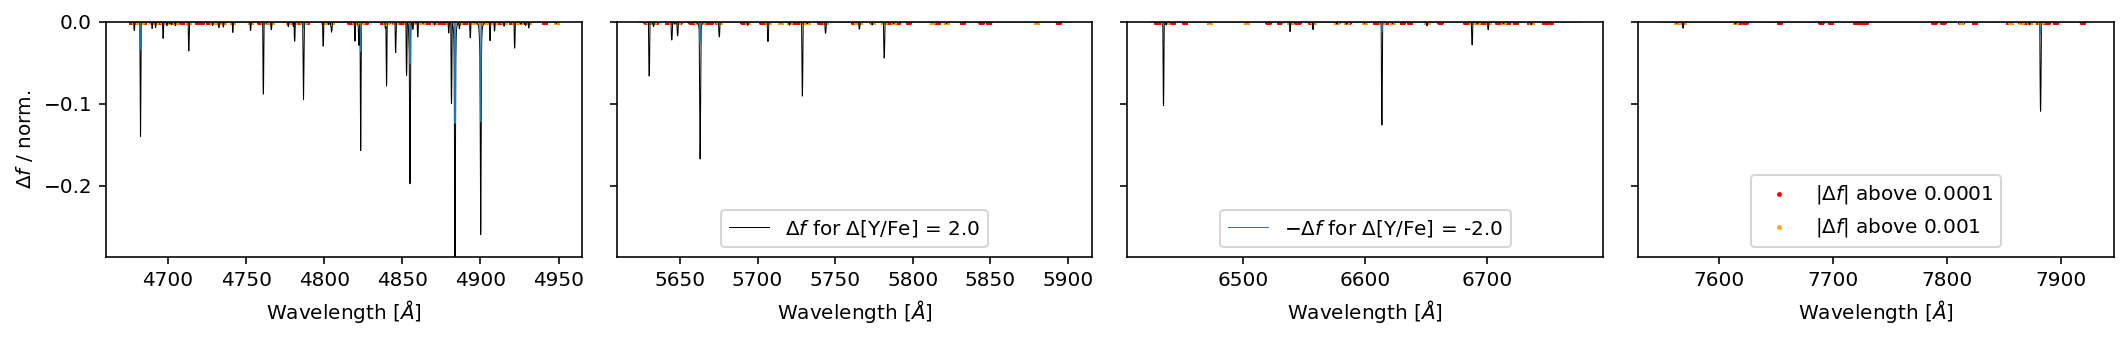

zr_fe 1.0
0.0001:    8.5% 5451
0.001:    3.3% 2104


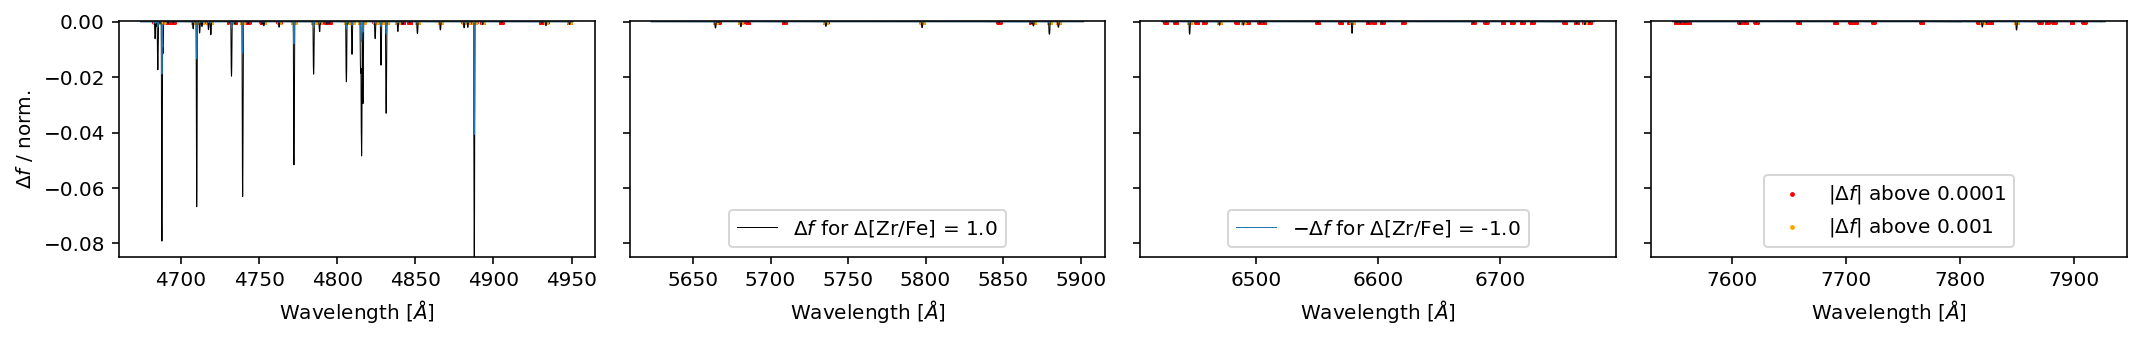

mo_fe 1.0
0.0001:    4.0% 2593
0.001:    0.9% 585


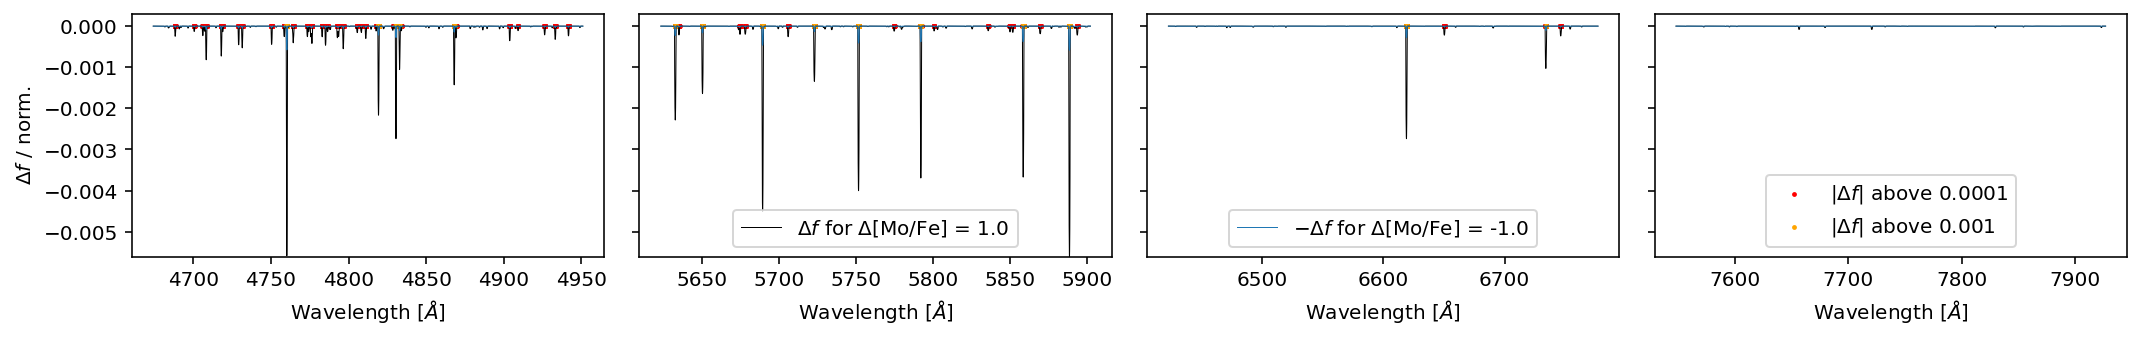

ru_fe 1.0
0.0001:    3.2% 2077
0.001:    1.0% 661


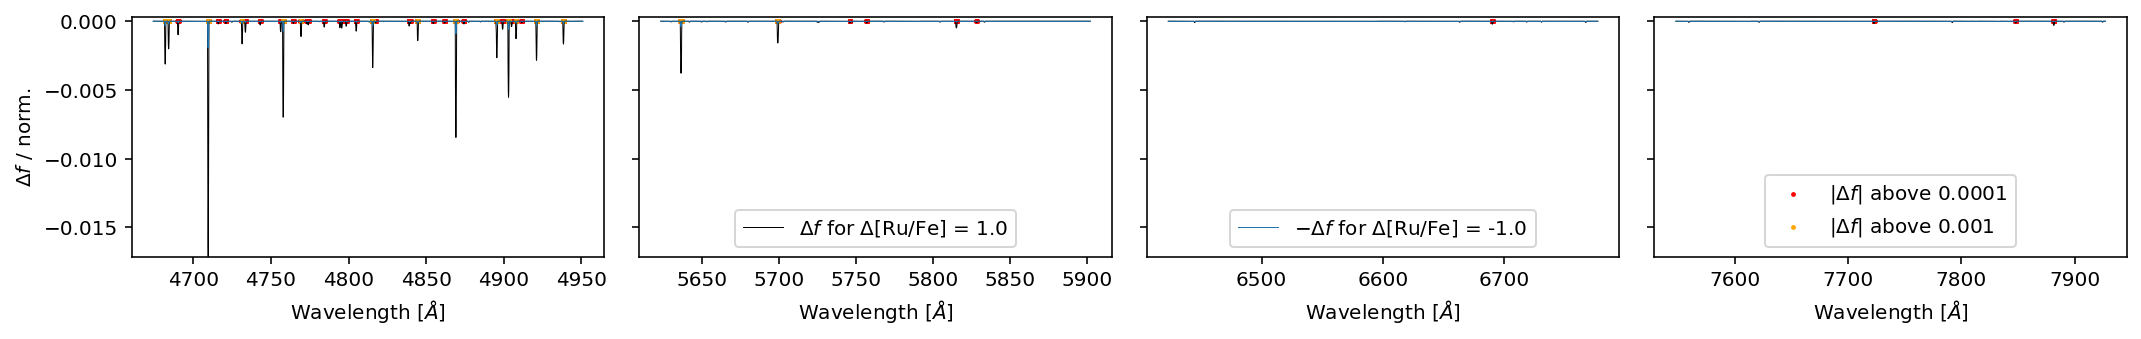

ba_fe 2.0
0.0001:    13.8% 8861
0.001:    6.2% 3990


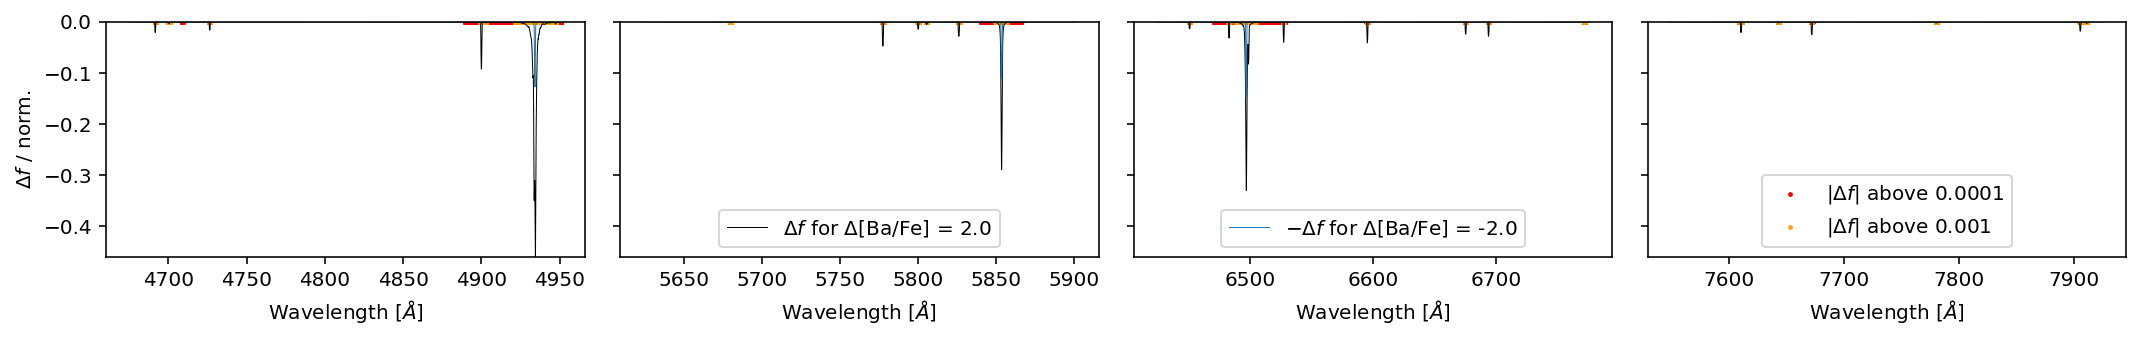

la_fe 1.0
0.0001:    4.5% 2907
0.001:    3.3% 2127


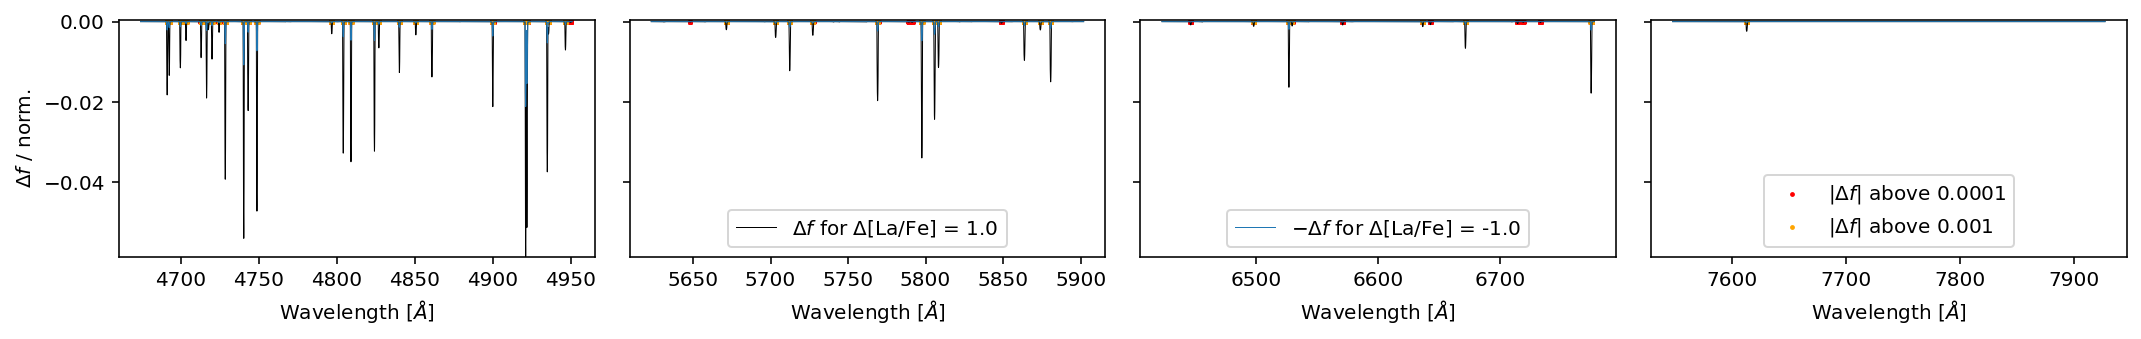

ce_fe 1.0
0.0001:    51.4% 32983
0.001:    22.5% 14424


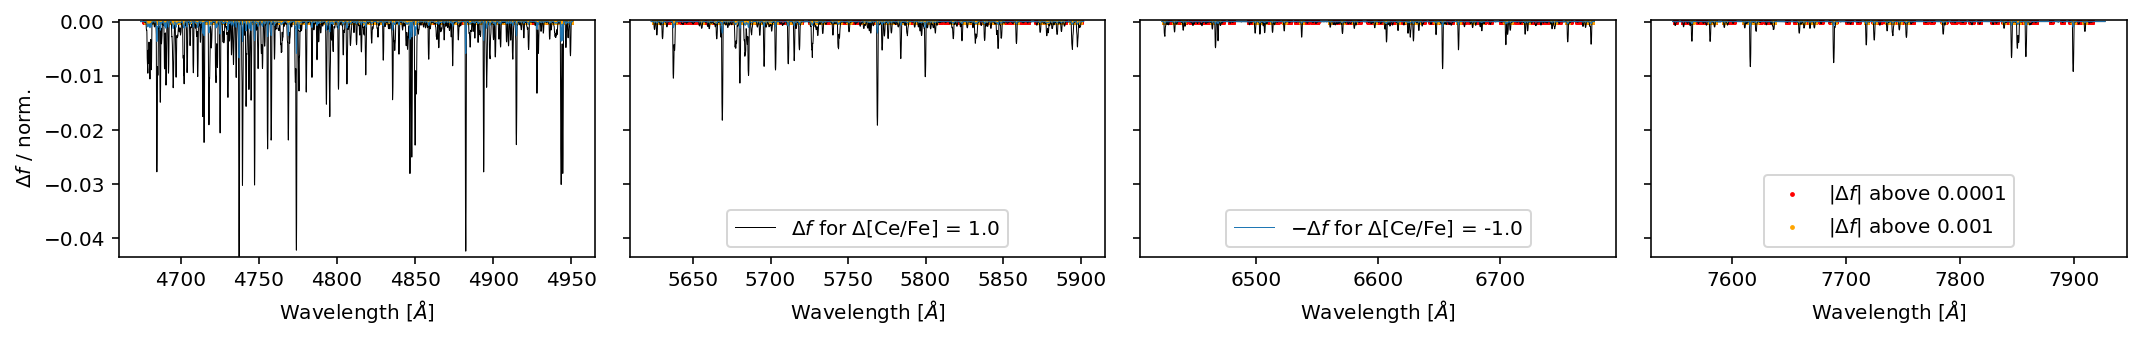

nd_fe 1.0
0.0001:    16.5% 10608
0.001:    10.3% 6585


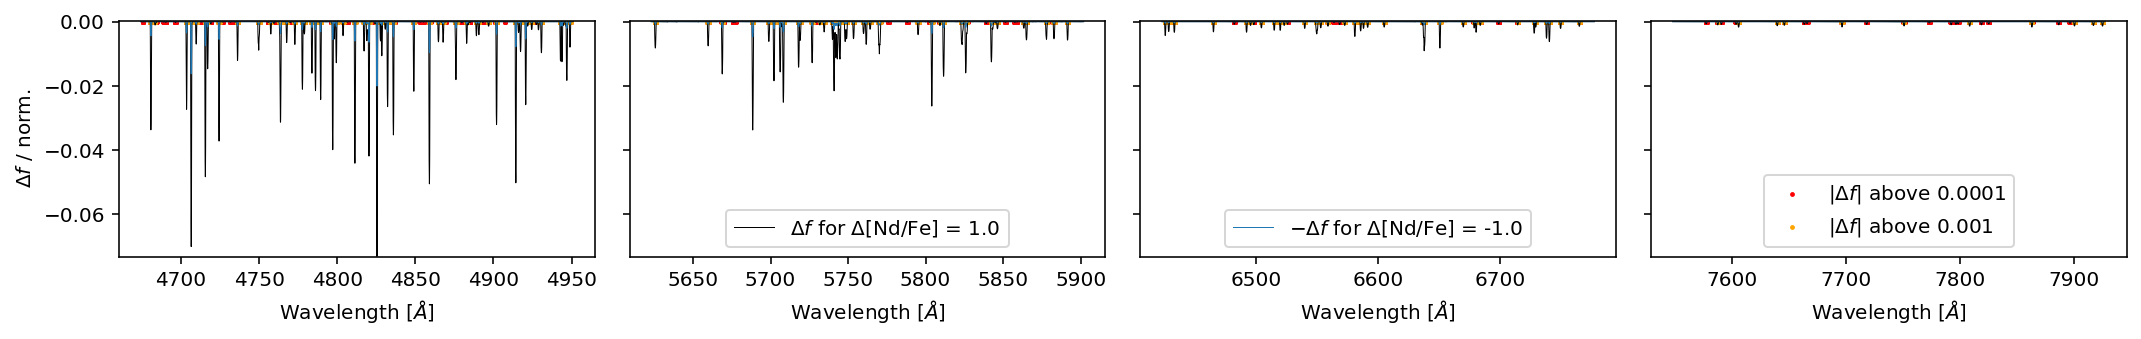

sm_fe 1.0
0.0001:    13.6% 8735
0.001:    6.1% 3903


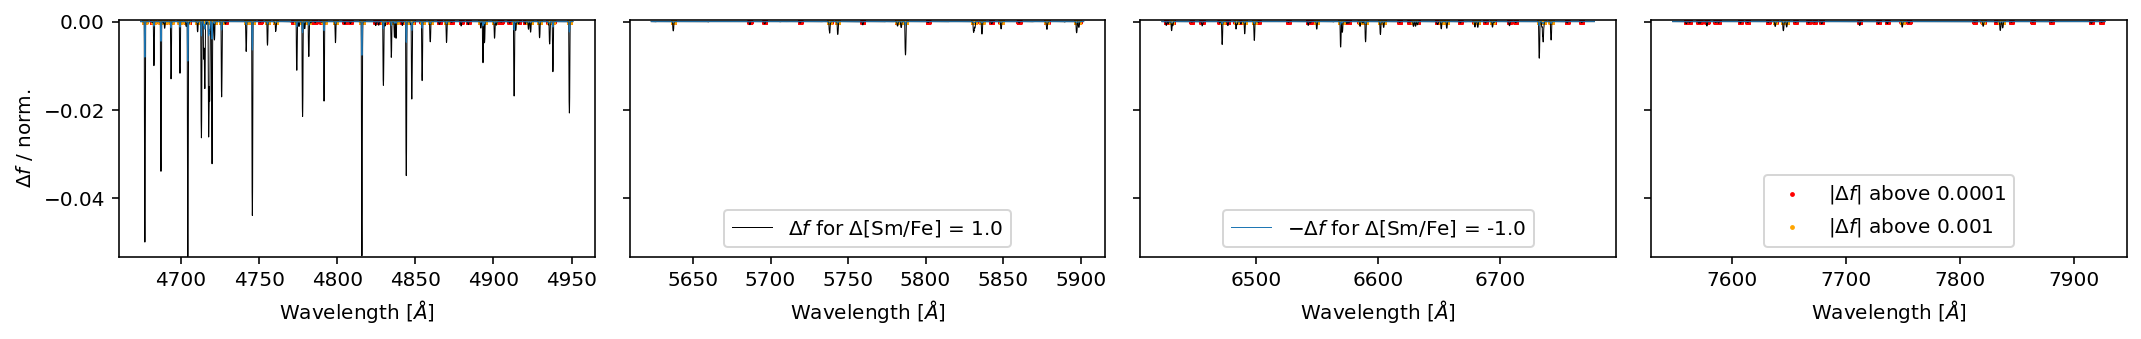

eu_fe 1.0
0.0001:    0.5% 307
0.001:    0.3% 186


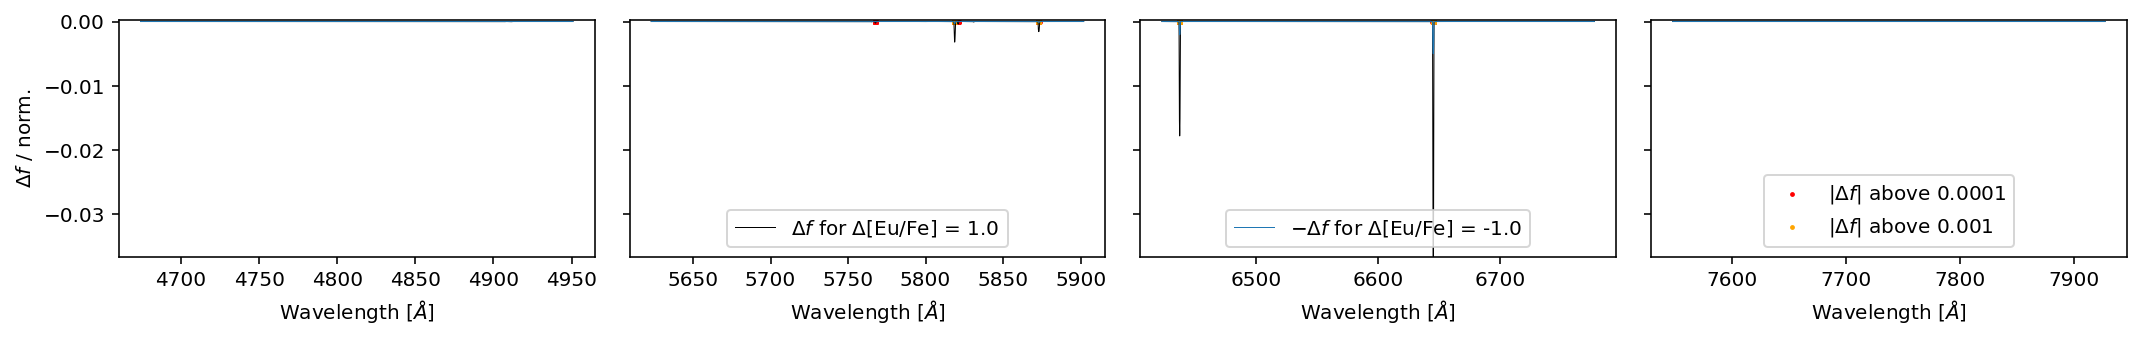

In [37]:
grid_masks = Table()

percentage_used = []

for label_index, label in enumerate(labels):
    print(label, training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0])
    
    threshold1 = 0.0001
    threshold2 = 0.001
    
    total = len(gradient_spectra_up)
    below_threshold1 = len(np.where(np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold1)[0])
    below_threshold2 = len(np.where(np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold2)[0])
    
    print(str(threshold1)+':   ',"{:.1f}".format(100*below_threshold1/total)+'%',below_threshold1)
    print(str(threshold2)+':   ',"{:.1f}".format(100*below_threshold2/total)+'%',below_threshold2)
    
    percentage_used.append([fancy_labels[label_index], r'$\pm$'+str(training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0]), "{:.1f}".format(100*below_threshold1/total),"{:.1f}".format(100*below_threshold2/total)])
    
    above_threshold1 = (np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold1)
    above_threshold2 = (np.max([np.abs(gradient_spectra_up[label]),np.abs(gradient_spectra_down[label])],axis=0) >= threshold2)

    grid_masks[label] = above_threshold2
    
    f, gs = plt.subplots(1,4,figsize=(15,2.5),sharey=True)
    for ccd in [1,2,3,4]:
        plot_label = '_nolegend_'
        if ccd == 2:
            plot_label = r'$\Delta f$ for $\Delta$'+fancy_labels[label_index]+' = '+str(training_set_vsini0[label][2+label_index]-training_set_vsini0[label][0])
        in_ccd = (gradient_spectra_up['wave'] > (3+ccd)*1000) & (gradient_spectra_up['wave'] < (4+ccd)*1000)
        ax=gs[ccd-1]
        ax.plot(
            gradient_spectra_up['wave'][in_ccd],
            gradient_spectra_up[label][in_ccd],
            c='k',lw=0.5,label = plot_label
        )
        plot_label = '_nolegend_'
        if ccd == 3:
            plot_label = r'$-\Delta f$ for $\Delta$'+fancy_labels[label_index]+' = '+str(training_set_vsini0[label][37+label_index]-training_set_vsini0[label][0])
        ax.plot(
            gradient_spectra_down['wave'][in_ccd],
            -gradient_spectra_down[label][in_ccd],
            c='C0',lw=0.5,label = plot_label
        )
        ax.set_xlabel(r'Wavelength [$\AA$]')
        if ccd==1:
            ax.set_ylabel(r'$\Delta f~/~\mathrm{norm.}$')
        plot_label = '_nolegend_'
        if ccd == 4:
            plot_label = r'$\vert\Delta f\vert$ above '+str(0.0001)
        ax.scatter(
            gradient_spectra_up['wave'][(above_threshold1 & in_ccd)],
            np.zeros(len(np.where(above_threshold1 & in_ccd==True)[0])),
            c='red',s=2,label=plot_label
        )
        plot_label = '_nolegend_'
        if ccd == 4:
            plot_label = r'$\vert\Delta f\vert$ above '+str(0.001)
        ax.scatter(
            gradient_spectra_up['wave'][(above_threshold2 & in_ccd)],
            np.zeros(len(np.where(above_threshold2 & in_ccd==True)[0])),
            c='orange',s=2,label=plot_label
        )
        ax.set_ylim(
            np.min([np.min(gradient_spectra_up[label]),-3*threshold1]),
            np.max([np.max(gradient_spectra_up[label]),3*threshold1])
        )
        if ccd in [2,3,4]:
            if label not in ['teff']:
                ax.legend(loc='lower center')
            else:
                ax.legend()
    plt.tight_layout()
    # Save, if we are looking at the Sun!
    if grid_index in [1931]:
        plt.savefig('../../galah_dr4_paper/figures/gradient_spectrum_'+str(grid_index)+'_'+label+'.png',dpi=200,bbox_inches='tight')
        plt.show()
    plt.close()


In [40]:
table_text = [
[r'\begin{table}[h!]'],
[r'    \centering'],
[r'    \caption{Example of mask estimation for \textit{The Cannon} model creation. Listed are percentages of the spectrum that respond to an in-/decrease of each label above 0.001 and 0.0001 of the normalised flux.}'],
[r'    \label{tab:cannon_mask_percentage}'],
[r'    \begin{tabular}{cccc}'],
[r'    \hline \hline'],
[r'    Label &  Label change & $\vert \Delta f \vert > 0.001~/~\%$ & $\vert \Delta f \vert > 0.0001~/~\%$ \\'],
[r'    \hline']
]
for each in percentage_used:
    table_text.append([r'    '+each[0]+' & '+each[1]+' & '+each[3]+' & '+each[2]+r' \\'])
table_text.append([r'    \hline'])
table_text.append([r'    \end{tabular}'])
table_text.append([r'\end{table}'])

np.savetxt('../../galah_dr4_paper/tables/cannon_mask_percentage_1931.tex',np.array(table_text),fmt='%s')

In [39]:
Path('masks/'+teff_logg_feh_name).mkdir(parents=True, exist_ok=True)

gradient_spectra_up.write('masks/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_gradient_spectra_up.fits',overwrite=True)
gradient_spectra_down.write('masks/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_gradient_spectra_down.fits',overwrite=True)
grid_masks.write('masks/'+teff_logg_feh_name+'/'+teff_logg_feh_name+'_masks.fits',overwrite=True)